# Plot some first SPECS Calculations for Eriswil


In [2]:
%matplotlib inline
#%matplotlib widget

In [3]:
import json
import glob
import numpy as np
import xarray as xr
import dask
from tqdm.auto import tqdm

import thermodynamic_variables as td
import vizz 

from typing import Dict
import copy
import multiprocessing
import concurrent.futures
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import re
from ipywidgets import interact, widgets, fixed

import datetime
import importlib

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'mycmap', [
        (0, 'white'), (0.2, 'blue'), (0.4, 'cyan'), (0.5, 'lime'), 
        (0.6, 'yellow'), (0.9, 'red'), (1, 'purple')
        ]
    ) 

# List Available COSMO-SPECS NetCDF Output Files

In [51]:
plots_path = '/work/bb1262/user/schimmel/cosmo-specs-torch/python/plots'
data_path = '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/' # fabians project
#data_path = '/work/bb1178/schimmel/COSMO-SPECS/testcases/RUN_ERISWILL_TESTCASE01/' # roland project
#meta_path = data_path + 'cs-eriswil__20230821_172639.json'
meta_path = data_path + 'cs-eriswil__20230830_111543.json'

date_str = '2023020809'


file_paths = glob.glob( data_path + '*.nc' )

m_files  = sorted([path for path in file_paths if path.rsplit('/', 1)[-1].startswith("M_")])
d3_files = sorted([path for path in file_paths if path.rsplit('/', 1)[-1].startswith("3D_")])

sorted(file_paths)



['/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/3D_20230821_172639.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/3D_20230821_172722.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/3D_20230821_172859.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/3D_20230821_172929.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/3D_20230821_173020.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/3D_20230821_173051.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/3D_20230821_173224.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/3D_20230821_173311.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testc

# Load files from Meta Data

In [52]:
with open(meta_path) as f:
   metadata = json.load(f)

print(metadata)


meta_file_list = [data_path + '3D_' + file + '.nc' for file in metadata.keys()]
d3_files = meta_file_list
meta_file_list

{'20230830_111543': {'starttime': '1693386943', 'job_id': '6702500', 'nodeX': 'l10292', 'domain': '42x32', 'LMGRID.startlat_tot': '-0.08', 'LMGRID.startlon_tot': '-0.08', 'LMGRID.pollat': '42.920', 'LMGRID.pollon': '-172.149', 'LMGRID.dlon': '0.005', 'LMGRID.dlat': '0.005', 'LMGRID.ie_tot': '42', 'LMGRID.je_tot': '32', 'LMGRID.ke_tot': '50', 'SBM_PAR.lsbm': '.true.', 'SBM_PAR.iimfr': '10', 'SBM_PAR.ifrier': '1', 'SBM_PAR.idepo': '0', 'SBM_PAR.imelt': '1', 'SBM_PAR.ikofr': '1', 'SBM_PAR.ibrea': '1', 'SBM_PAR.ikoll': '2', 'SBM_PAR.iice': '1', 'SBM_PAR.iinsol': '7', 'SBM_PAR.ikeis': '1', 'SBM_PAR.iideal': '1', 'SBM_PAR.epsi': '0.5', 'SBM_PAR.itimemax': '4', 'SBM_PAR.iap': '1', 'SBM_PAR.ihomfr': '1', 'SBM_PAR.mpstepsmax': '1', 'SBM_PAR.fd4_blsize': '2', 'SBM_PAR.2': '2', 'SBM_PAR.4': '4', 'SBM_PAR.nc_output_hcomb': '0', 'SBM_PAR.10800': '10800', 'SBM_PAR.120': '120', 'SBM_PAR.outputname': '3D_20230830_111543', 'SBM_PAR.output_groups': '1100001', 'SBM_PAR.fd4_lbmethod': '3', 'SBM_PAR.fd4_lb

['/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/3D_20230830_111543.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/3D_20230830_111635.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/3D_20230830_111709.nc']

# Read NetCDF Files

In [53]:
data = {}

# Load each file into a separate xarray Dataset and store in the dictionary
for file in d3_files:# + other_files:
    # Use the file name as the key
    key = file.rsplit('/', 1)[-1][:-3]
    
    # Open the dataset and assign to the dictionary
    data[key] = xr.open_mfdataset(file, preprocess=vizz.add_metadata)

date_list=list(data.keys())
date_list


['3D_20230830_111543', '3D_20230830_111635', '3D_20230830_111709']

In [54]:


# time: 182  z: 50  y: 26  x: 36  bin: 66


# Table of available COMSO-SPECS runs

In [55]:
import pandas as pd

def create_table(string_list):
    flare_types = {
        "Flare Emission (1e7)": "8.0e7",
        "Flare Emission (1e8)": "8.0e8",
        "Flare Emission (1e9)": "8.0e9",
        "No Flare Emission": "no"
    }
    
    data_dict = {key: [] for key in flare_types.keys()}
    inp_values = ["1000", "100", "10"]
    
    for inp in inp_values:
        for flare, code in flare_types.items():
            for item in string_list:
                if f"BINP{inp}_FE{code}" == item:
                    data_dict[flare].append(item[4:])
                    
    df = pd.DataFrame(data_dict, index=inp_values)
    df.index.name = "INP"
    return df


#df = create_table(data.keys())
#df.index.name = "INP"
#print(df.to_string(line_width=1000))

# Plot a horizontal slice of the entire domain

46.9839 47.143899999999995 7.7181 7.8781
60


/work/bb1262/user/schimmel/cosmo-specs-torch/python/vizz.py:361: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self.fig.subplots_adjust(hspace=0.3, wspace=0.15, left=0.15, right=0.88, top=0.82, bottom=0.17)  # make space for colorbar


0it [00:00, ?it/s]

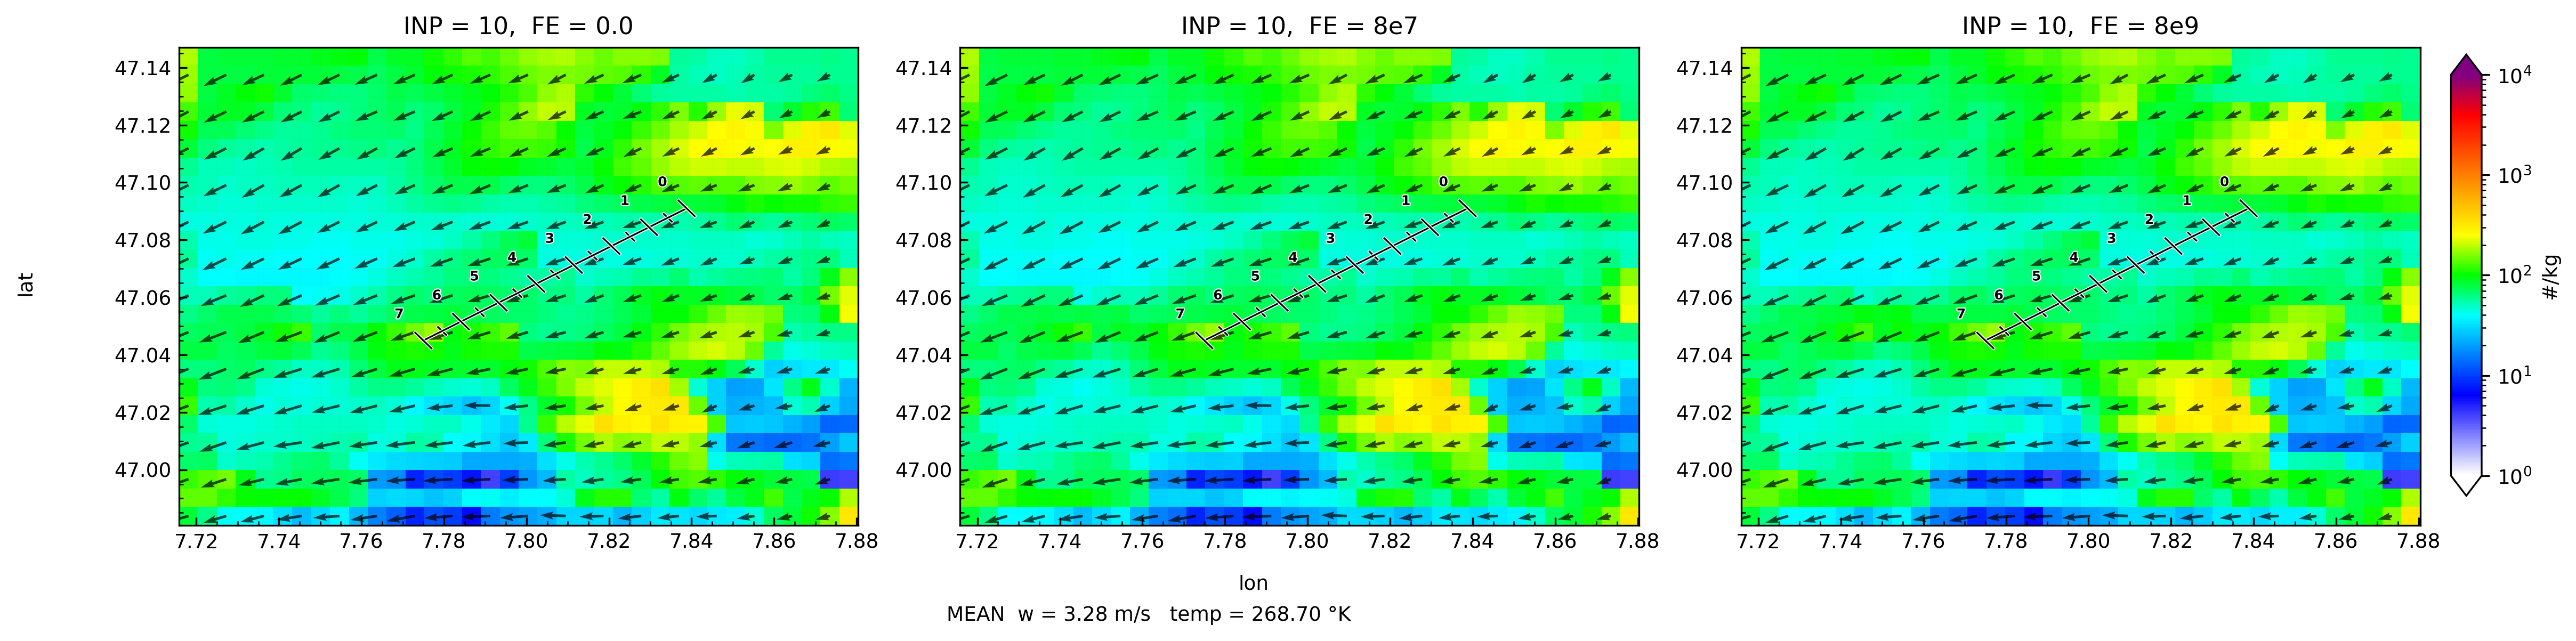

In [59]:

importlib.reload(vizz)

key = next(iter(metadata))
var_name = 'nf'

plot1 = vizz.MultiPanelPlot(
    data, 
    metadata    = metadata,
    varname     = var_name, 
    nrows       = 1, 
    ncols       = 3, 
    mode        = 'area', 
    vmin        = 1.0, 
    vmax        = 1.0e4,
    timeframe   = 'single', # 'all', 'single'
    timestep0   = 60,
    latlon      = True,
    windvectors = True
    )



# Define start and end points for the ruler
lat_start, lon_start = 47.045, 7.775
lat_end, lon_end = 47.0910, 7.8388
iha, ihe = 41, 49

plot1.add_ruler(lat_start, lon_start, lat_end, lon_end)


for i in tqdm(range(50, 50)):

    tit = f"{data[key].time.values[i]}"
    dt0 = datetime.datetime.strptime(metadata[key[3:]]["RUNCTL.ydate_ini"], "%Y%m%d%H")
    dti = dt0 + i*datetime.timedelta(seconds=15)
    tit = f'{str(dti)} - height: {plot1.height[ihe]:.3f} - {plot1.height[iha]:.3f} [km]\n\
          sum of {data[next(iter(data))][var_name].attrs["long_name"]} ({var_name})'
    
    plot1.display(timestep=i, title=tit)
    plot1.save_figure(f'/{plots_path}/{str(i).zfill(3)}_nf.png')

In [28]:

# Example usage:
iha, ihe = 41, 49
var_name = 'nf'
ds = data['3D_20230821_172722'][var_name]

idX, idY = vizz.line_indices(plot1.y, plot1.x, lat_start, lon_start, lat_end, lon_end)

n_profile = idX.shape[0]
print(n_profile)


print('Print Metegoram station list for track along the flare emission plume\n')
for i in range(n_profile):
    print(idX[i], ',' , idY[i], ',' , f'{plot1.x[idX[i]]:.4f}', ',' , f'{plot1.y[idY[i]]:.4f}', ',' , f"'{str(i).zfill(2)}-' ,")


16
Print Metegoram station list for track along the flare emission plume

0 , 7 , 7.7707 , 47.0447 , '00-' ,
1 , 7 , 7.7753 , 47.0447 , '01-' ,
2 , 8 , 7.7798 , 47.0511 , '02-' ,
3 , 8 , 7.7844 , 47.0511 , '03-' ,
4 , 9 , 7.7890 , 47.0575 , '04-' ,
5 , 9 , 7.7936 , 47.0575 , '05-' ,
6 , 10 , 7.7981 , 47.0639 , '06-' ,
7 , 10 , 7.8027 , 47.0639 , '07-' ,
8 , 11 , 7.8073 , 47.0703 , '08-' ,
9 , 11 , 7.8118 , 47.0703 , '09-' ,
10 , 12 , 7.8164 , 47.0767 , '10-' ,
11 , 12 , 7.8210 , 47.0767 , '11-' ,
12 , 13 , 7.8256 , 47.0831 , '12-' ,
13 , 13 , 7.8301 , 47.0831 , '13-' ,
14 , 14 , 7.8347 , 47.0895 , '14-' ,
15 , 14 , 7.8393 , 47.0895 , '15-' ,


AttributeError: 'list' object has no attribute 'size'

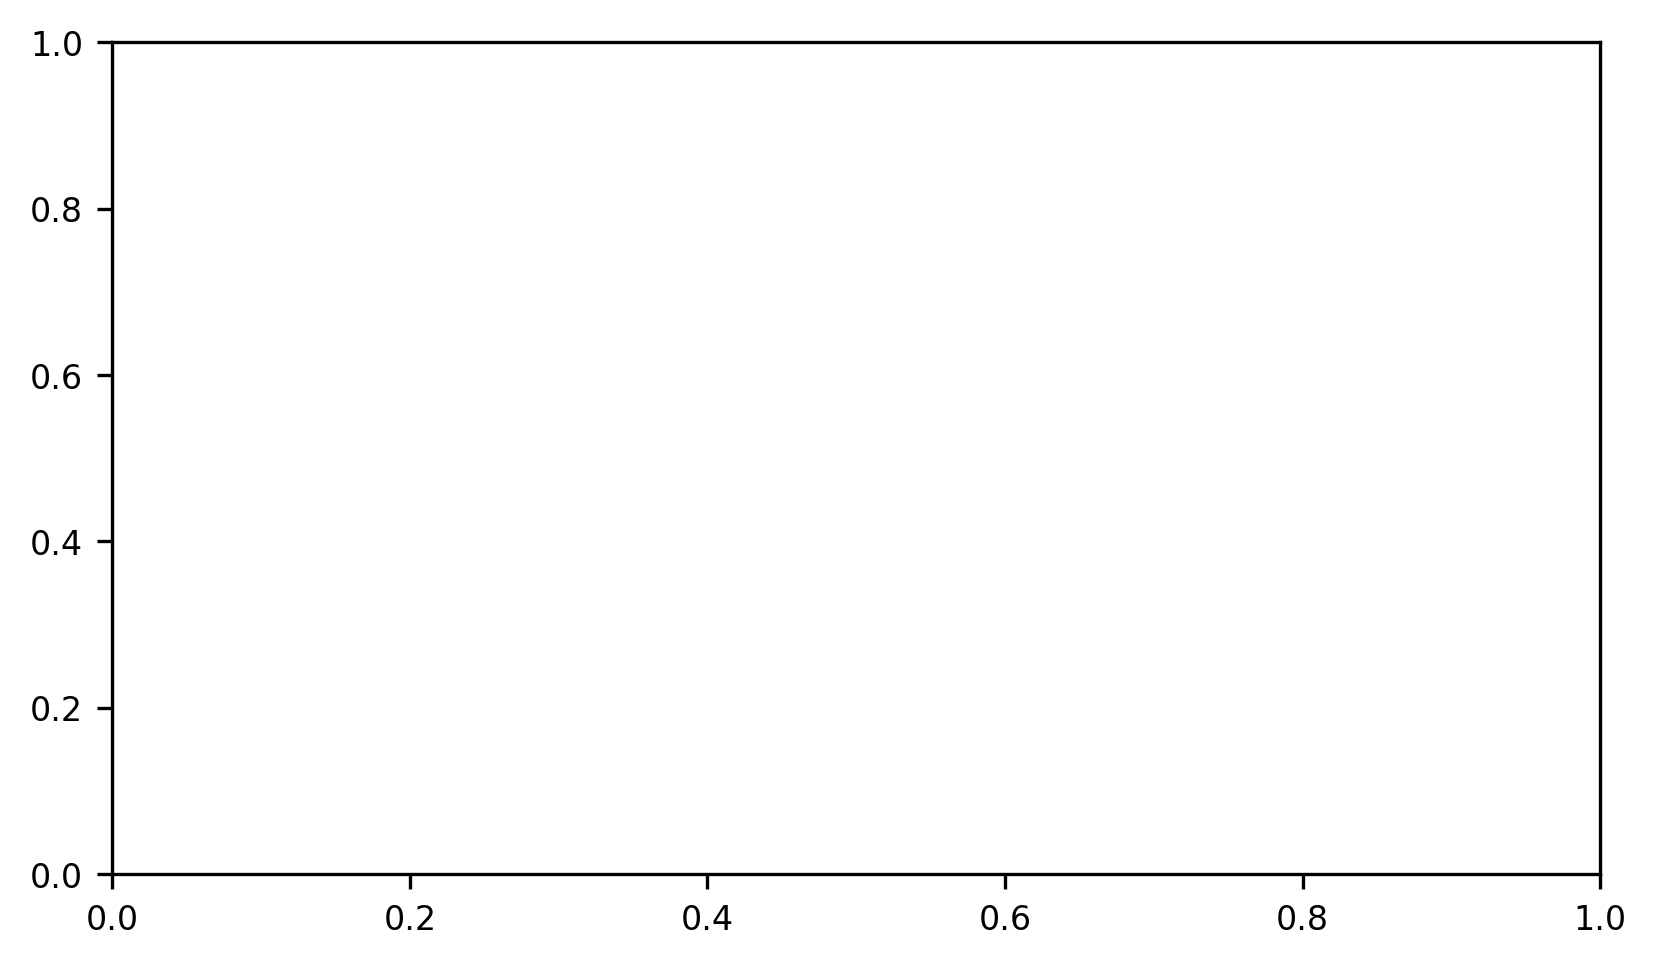

In [29]:

my_dpi = 300

plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(figsize=(1920/my_dpi, 1080/my_dpi), dpi=my_dpi)


xx = [f'{7*i/(n_profile-1):.2f}' for i in range(n_profile)]
yy = plot1.rgrenz

z0 = ds[:, iha:ihe, :, :, :].sum('z').values
zz = np.zeros((plot1.time.size, n_profile, plot1.bins.size))

for i in range(n_profile):
    zz[:, i, :] = z0[:, idY[i], idX[i], :]

tt = np.linspace(340, 480, 480-340)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'mycmap', [
        (0, 'white'), (0.2, 'blue'), (0.4, 'cyan'), (0.5, 'lime'), 
        (0.6, 'yellow'), (0.9, 'red'), (1, 'purple')
        ]
    ) 
norm = colors.LogNorm(1.0, 1.0e4)
cbar_ax = fig.add_axes([0.86, 0.21, 0.01, 0.6])  # adjust6 these values as needed
cbar = fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap=cmap), 
    cax=cbar_ax, 
    orientation='vertical', 
    extend='both', 
    )
cbar.set_label(f"[{ds.attrs['units']}]")
pmesh = ax.pcolormesh(xx[::-1], yy, zz[380, :, :].T, norm=norm, cmap=cmap)

fig.text(0.5, 0.1, 'distance from seeding [km]', ha='center', va='center')
fig.text(0.05, 0.45, 'radius [m]', ha='center', va='center', rotation='vertical')


ax.set_xticks(xx[::2])
ax.set_xticklabels(xx[::2])

ax.set_yscale('log')
ax.tick_params(which='both', direction='in')
ax.minorticks_on()
ax.grid(True, which='major', linestyle='--', linewidth='0.15', color='black', alpha=0.5)
ax.grid(True, which='minor', linestyle=':', linewidth='0.05', color='black', alpha=0.25)

fig.subplots_adjust(hspace=0.3, wspace=0.15, left=0.11, right=0.85, top=0.82, bottom=0.17)  # make space for colorbar

for iT in tqdm(range(720,720)):

    dt0 = datetime.datetime.strptime(metadata[key[3:]]["RUNCTL.ydate_ini"], "%Y%m%d%H")
    dti = dt0 + iT*datetime.timedelta(seconds=15)
    ax.set_title(f'{str(dti)} - height: {plot1.height[ihe]:.3f} - {plot1.height[iha]:.3f} [km]\n\
                 sum of {ds.attrs["long_name"]} ({var_name})', weight='bold')

    pmesh.set_array(zz[iT, :, :].ravel(order='F'))   
    fig.savefig(f'/{plots_path}/{str(iT).zfill(3)}_crosssection.png', dpi=my_dpi, facecolor='white')


In [ ]:
print(data[key]['ut'][:, :, 15, 15].values.min()*1.0e-5)
print(data[key]['ut'][:, :, 15, 15].values.max()*1.0e-5)

-46.781445910497496
6.511862418083917


Wind Speeds: [ 7.07106781 10.         11.18033989]
Wind Directions: [225.         270.          26.56505118]
Wind Speeds: 302632.43094664154
Wind Directions: 72.33499825328823


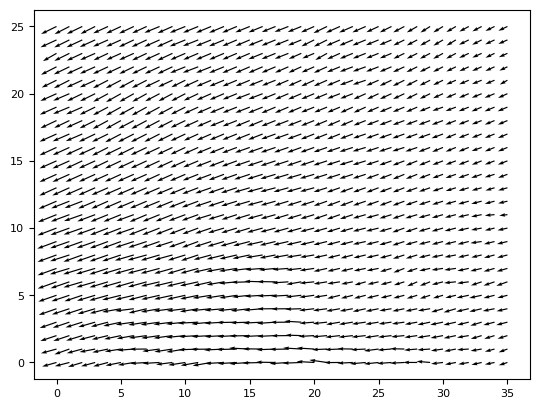

In [ ]:

def wind_speed_direction(u, v):
    # Calculate wind speed
    speed = np.sqrt(u**2 + v**2)
    
    # Calculate wind direction in degrees
    direction_rad = np.arctan2(u, v)
    direction_deg = np.degrees(direction_rad)
    
    # Adjust the direction to indicate the direction from which the wind is coming
    direction_from = (direction_deg + 180) % 360
    
    return speed, direction_from

# Example usage:
u = np.array([5, 10, -5])  # Example u components
v = np.array([5, 0, -10])  # Example v components
speed, direction = wind_speed_direction(u, v)
print(f"Wind Speeds: {speed}")
print(f"Wind Directions: {direction}")


t0= 380
hlim = (41, 45)
x = data[key].x.values
y = data[key].y.values
u = data[key]['ut'][t0, hlim[0]:hlim[1], :, :].mean('z').values
v = data[key]['vt'][t0, hlim[0]:hlim[1], :, :].mean('z').values
w = data[key]['wt'][t0, hlim[0]:hlim[1], :, :].mean('z').values

fig2, ax2 = plt.subplots()
ax2.quiver(x, y, u[:, :], v[:, :], scale=1.0e7)

speed, direction = wind_speed_direction(u.mean(), v.mean())
print(f"Wind Speeds: {speed}")
print(f"Wind Directions: {direction}")


In [ ]:
print(u[12,12],v[12,12],w[12,12])


-326728.28348111175 -109378.79141012815 -13513.185577457734


In [ ]:
data[key]

<xarray.Dataset>
Dimensions:  (time: 721, z: 50, y: 26, x: 36, bin: 66)
Dimensions without coordinates: time, z, y, x, bin
Data variables: (12/25)
    t        (time, z, y, x) float64 dask.array<chunksize=(721, 50, 26, 36), meta=np.ndarray>
    p0       (time, z, y, x) float64 dask.array<chunksize=(721, 50, 26, 36), meta=np.ndarray>
    pp       (time, z, y, x) float64 dask.array<chunksize=(721, 50, 26, 36), meta=np.ndarray>
    qv       (time, z, y, x) float64 dask.array<chunksize=(721, 50, 26, 36), meta=np.ndarray>
    rho0     (time, z, y, x) float64 dask.array<chunksize=(721, 50, 26, 36), meta=np.ndarray>
    rho      (time, z, y, x) float64 dask.array<chunksize=(721, 50, 26, 36), meta=np.ndarray>
    ...       ...
    qf       (time, z, y, x, bin) float64 dask.array<chunksize=(721, 50, 26, 36, 66), meta=np.ndarray>
    qfw      (time, z, y, x, bin) float64 dask.array<chunksize=(721, 50, 26, 36, 66), meta=np.ndarray>
    vtf      (time, z, y, x, bin) float64 dask.array<chunksize=(721, 50, 26, 36, 66), meta=np.ndarray>
    vti      (time, z, y, x) float64 dask.array<chunksize=(721, 50, 26, 36), meta=np.ndarray>
    blocks   (time, z, y, x) float64 dask.array<chunksize=(721, 50, 26, 36), meta=np.ndarray>
    weight   (time, z, y, x) float64 dask.array<chunksize=(721, 50, 26, 36), meta=np.ndarray>

In [ ]:
print(idX)
print(idY)

NameError: name 'idX' is not defined

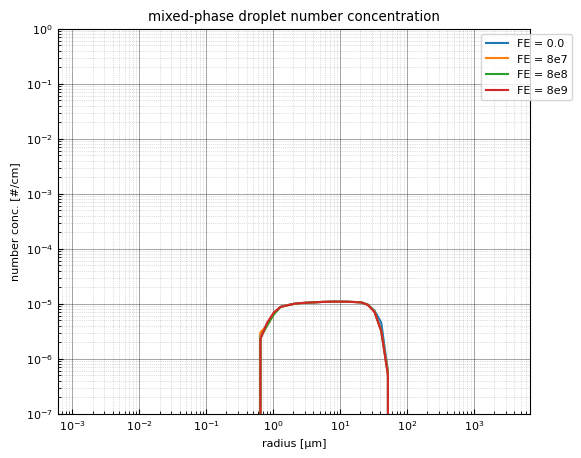

In [ ]:
date = '3D_20230821_172722'

t, h, x, y = 400, 42, 6, 10 
t, h, x, y = 400, 42, 6, 10

var = 'nf'
radius = vizz.RGRENZ * 1.0e6 # m to µm
fac = 1/np.diff(np.log10(radius)) * 1.0e-6

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
for date in date_list[:4]:
    air_density = data[date]['rho'][t, h, x, y].values
    spectra = data[date][var][t, h, x, y , :-1].values * air_density * fac 
    var_name = data[date][var].attrs['long_name']
    units = data[date][var].attrs['units']
    leg_label = metadata[date[3:]]['FLARE_SBM.flare_emission']

    ax.plot(radius[:-1], spectra, label=f'FE = {leg_label}')
    
ax.set_ylim(1.0e-7, 1.0e0)
ax.set(xlabel='radius [µm]', ylabel=f'number conc. [#/cm]', title=data[date]["nf"].attrs["long_name"])
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(which='both', direction='in')
ax.minorticks_on()
ax.grid(True, which='major', linestyle='-', linewidth='0.5', color='black', alpha=0.5)
ax.grid(True, which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.25)

plt.legend(loc='upper right',bbox_to_anchor=(1.1, 1))
plt.subplots_adjust(right=0.8)

# todo #/kg to #/cm3

# Plot a single profile for a specific location

In [ ]:
# plot2 = MultiPanelPlot(
#     data, 
#     metadata    = metadata,
#     varname     = 'nf', 
#     nrows       = 1, 
#     ncols       = 4, 
#     mode        = 'profile',
#     ymin        = 0, 
#     ymax        = 12,
#     vmin        = 1, 
#     vmax        = 1.0e6,
#     ).interactive()

In [ ]:
# plot3 = MultiPanelPlot(
#     data, 
#     metadata    = metadata,
#     varname     = 'qw', 
#     nrows       = 1, 
#     ncols       = 1, 
#     mode        = 'profile',
#     ymin        = 0, 
#     ymax        = 12,
#     vmin        = 1e-12, 
#     vmax        = 1e-6,
#     ).interactive()

In [ ]:
# plot4 = vizz.MultiPanelPlot(
#     data,
#     metadata    = metadata,
#     varname     = 'nf',
#     nrows       = 1,
#     ncols       = 2,
#     mode        = 'profile',
#     ymin        = 0,
#     ymax        = 2,
#     vmin        = 1,
#     vmax        = 1.0e6,
#     ).interactive()

# Plot a time series of a specific location

In [ ]:
# plot5 = vizz.MultiPanelPlot(
#     data, 
#     metadata    = metadata,
#     varname     = 'nf', 
#     nrows       = 1, 
#     ncols       = 2, 
#     mode        = 'timeseries',
#     ymin        = 0, 
#     ymax        = 2,
#     idX         = 8,
#     idY         = 10,
#     ).interactive()

0it [00:00, ?it/s]

46.999900000000004 47.1599 7.7707 7.9307
0


/work/bb1262/user/schimmel/cosmo-specs-torch/python/vizz.py:205: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  


46.999900000000004 47.1599 7.7707 7.9307
0


/work/bb1262/user/schimmel/cosmo-specs-torch/python/vizz.py:205: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  


46.999900000000004 47.1599 7.7707 7.9307
0


/work/bb1262/user/schimmel/cosmo-specs-torch/python/vizz.py:205: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  


46.999900000000004 47.1599 7.7707 7.9307
0


/work/bb1262/user/schimmel/cosmo-specs-torch/python/vizz.py:205: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  


46.999900000000004 47.1599 7.7707 7.9307
0


/work/bb1262/user/schimmel/cosmo-specs-torch/python/vizz.py:205: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  


46.999900000000004 47.1599 7.7707 7.9307
0


/work/bb1262/user/schimmel/cosmo-specs-torch/python/vizz.py:205: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  


46.999900000000004 47.1599 7.7707 7.9307
0


/work/bb1262/user/schimmel/cosmo-specs-torch/python/vizz.py:205: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  


46.999900000000004 47.1599 7.7707 7.9307
0


/work/bb1262/user/schimmel/cosmo-specs-torch/python/vizz.py:205: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  


46.999900000000004 47.1599 7.7707 7.9307
0


/work/bb1262/user/schimmel/cosmo-specs-torch/python/vizz.py:205: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  


46.999900000000004 47.1599 7.7707 7.9307
0


/work/bb1262/user/schimmel/cosmo-specs-torch/python/vizz.py:205: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  


46.999900000000004 47.1599 7.7707 7.9307
0


/work/bb1262/user/schimmel/cosmo-specs-torch/python/vizz.py:205: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  


46.999900000000004 47.1599 7.7707 7.9307
0


/work/bb1262/user/schimmel/cosmo-specs-torch/python/vizz.py:205: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  


46.999900000000004 47.1599 7.7707 7.9307
0


/work/bb1262/user/schimmel/cosmo-specs-torch/python/vizz.py:205: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  


46.999900000000004 47.1599 7.7707 7.9307
0


/work/bb1262/user/schimmel/cosmo-specs-torch/python/vizz.py:205: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  


46.999900000000004 47.1599 7.7707 7.9307
0


/work/bb1262/user/schimmel/cosmo-specs-torch/python/vizz.py:205: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  


46.999900000000004 47.1599 7.7707 7.9307
0


/work/bb1262/user/schimmel/cosmo-specs-torch/python/vizz.py:205: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  


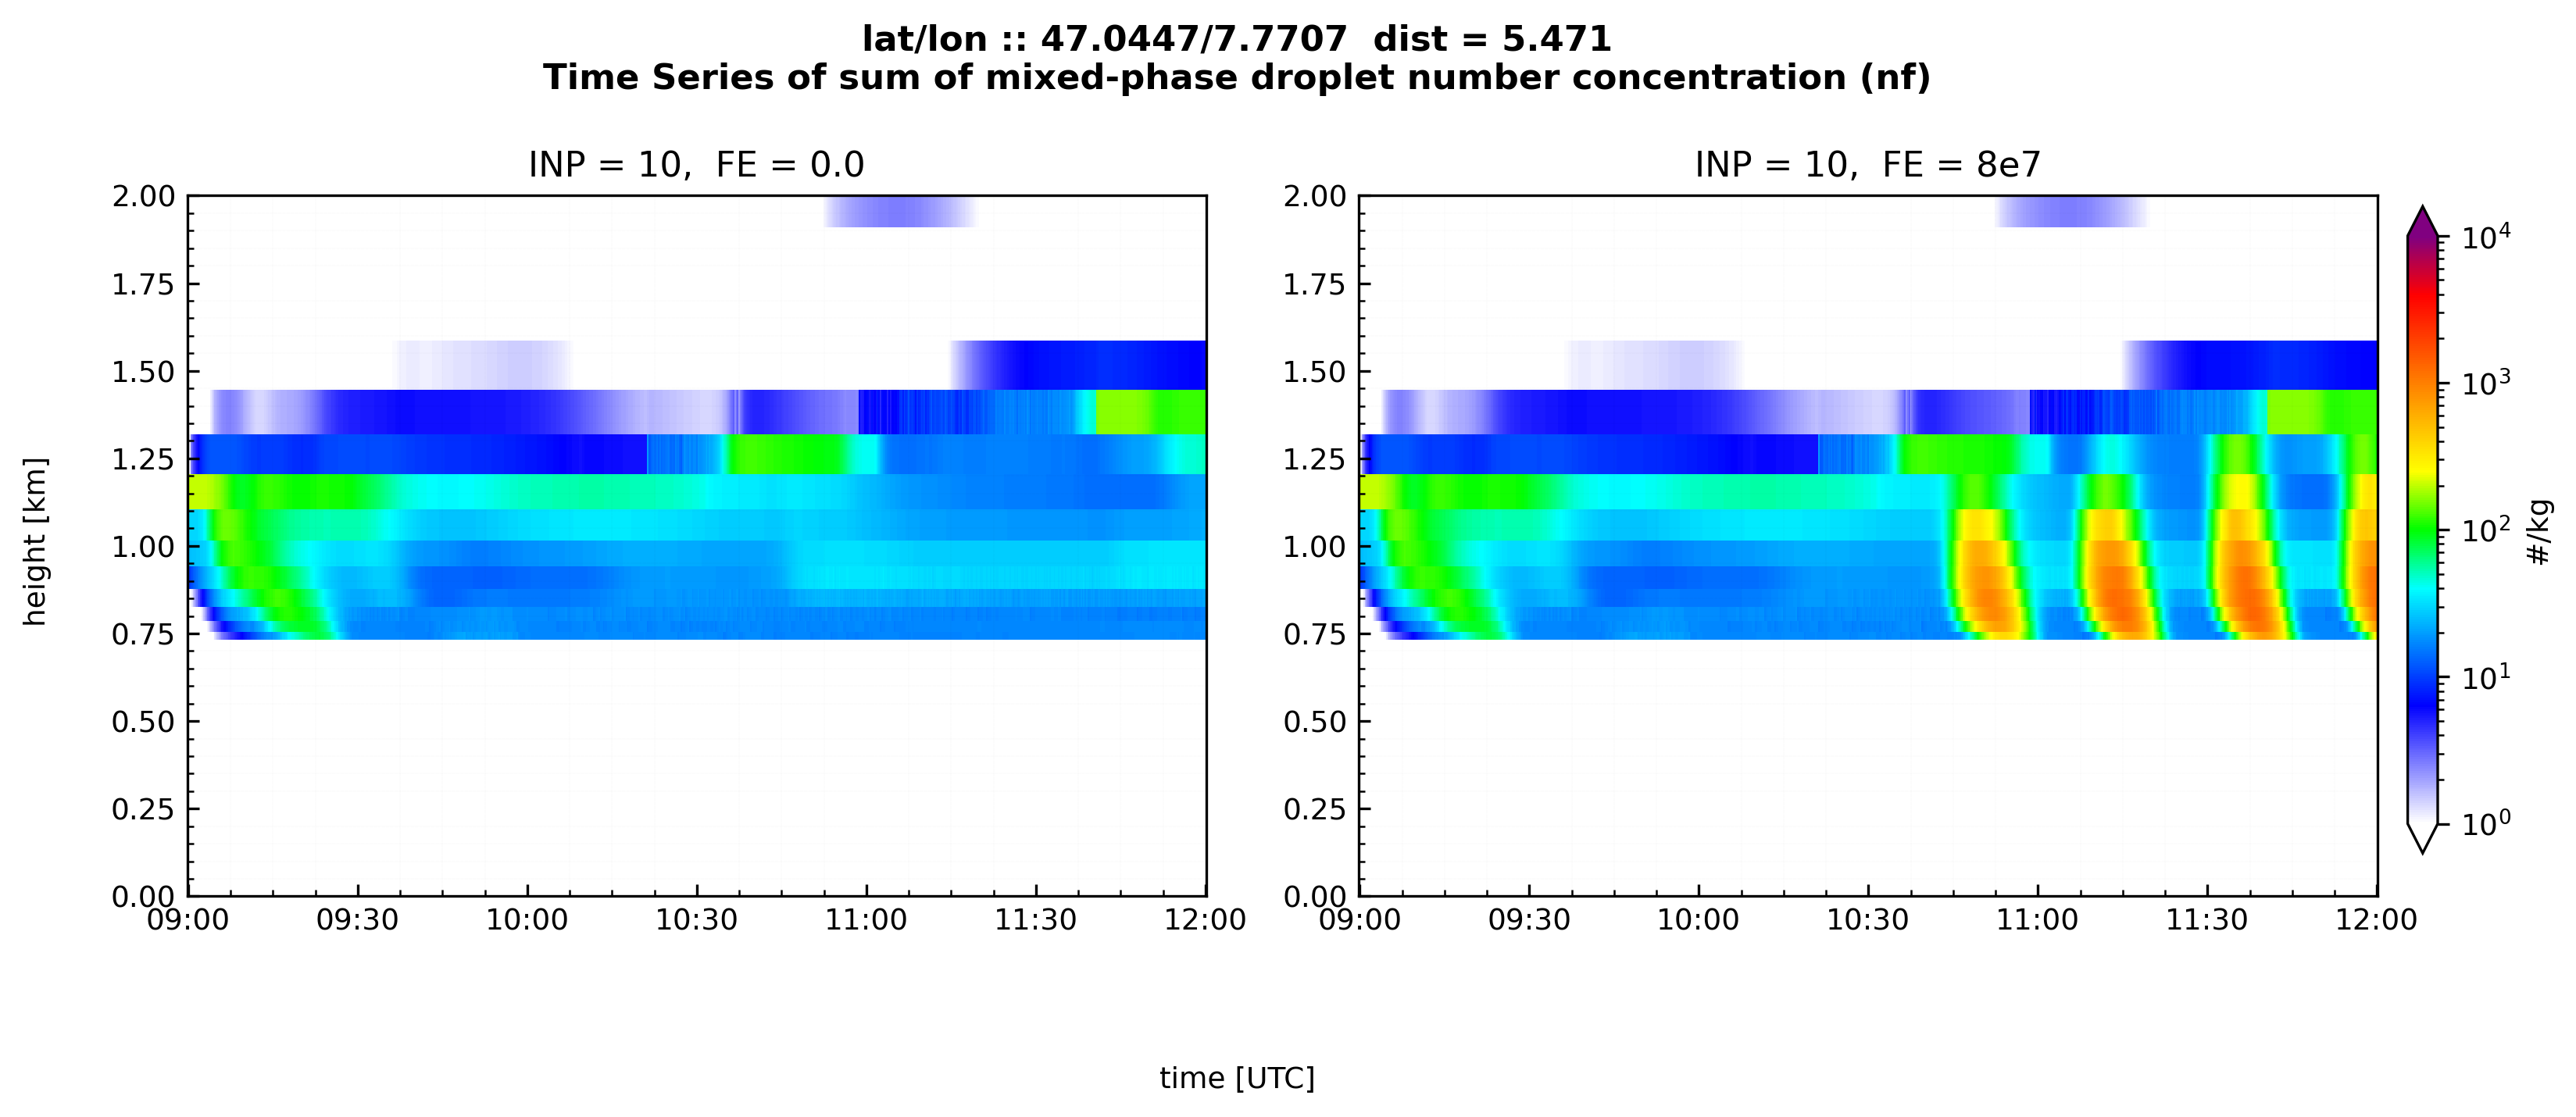

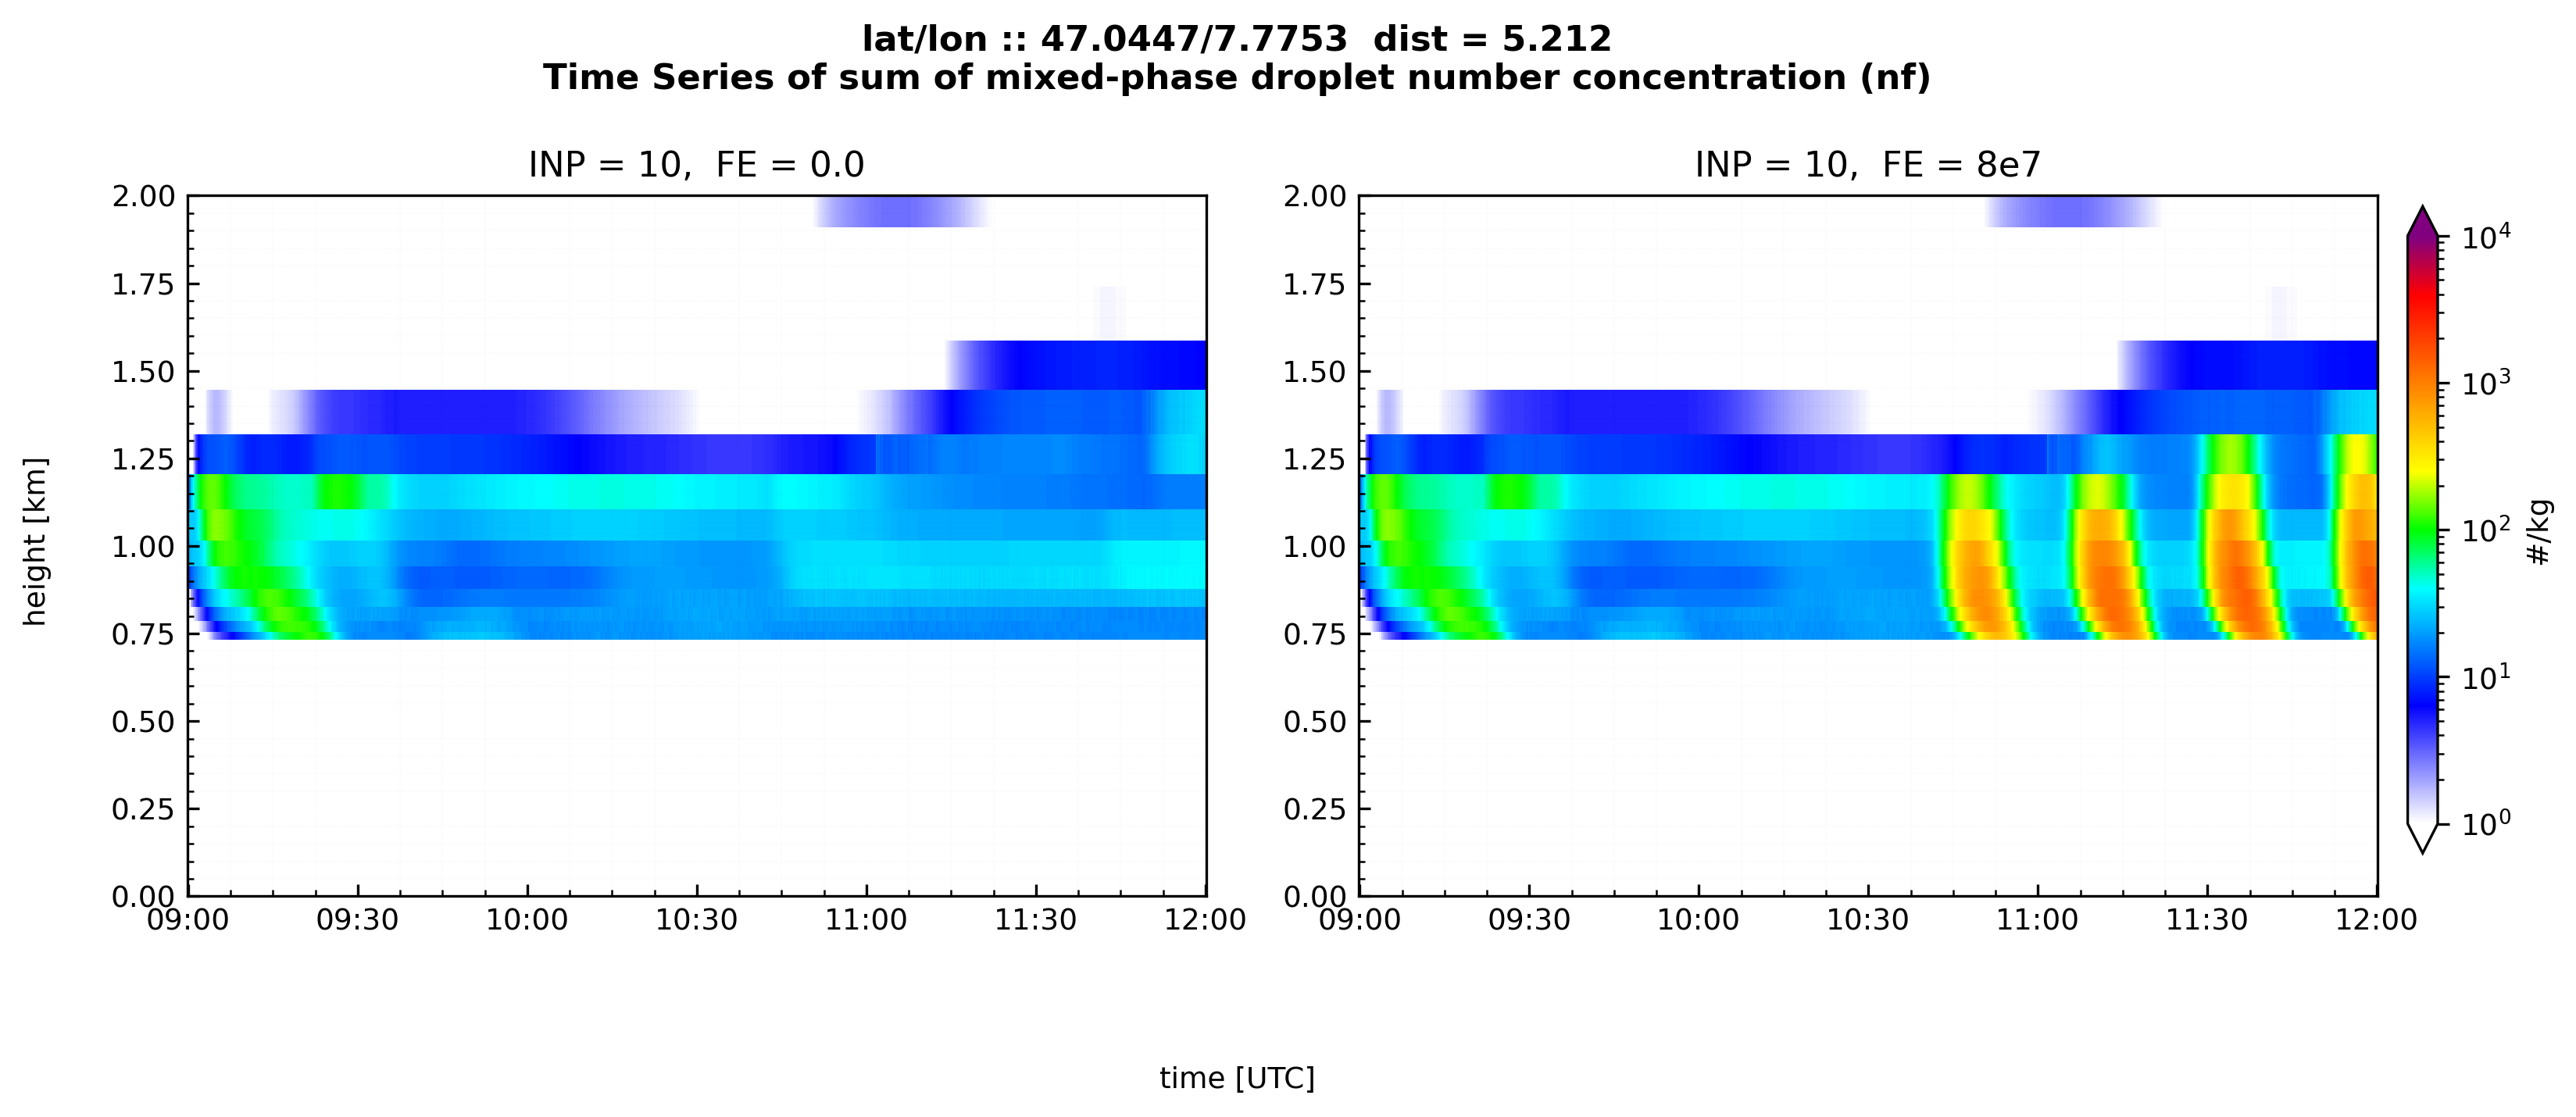

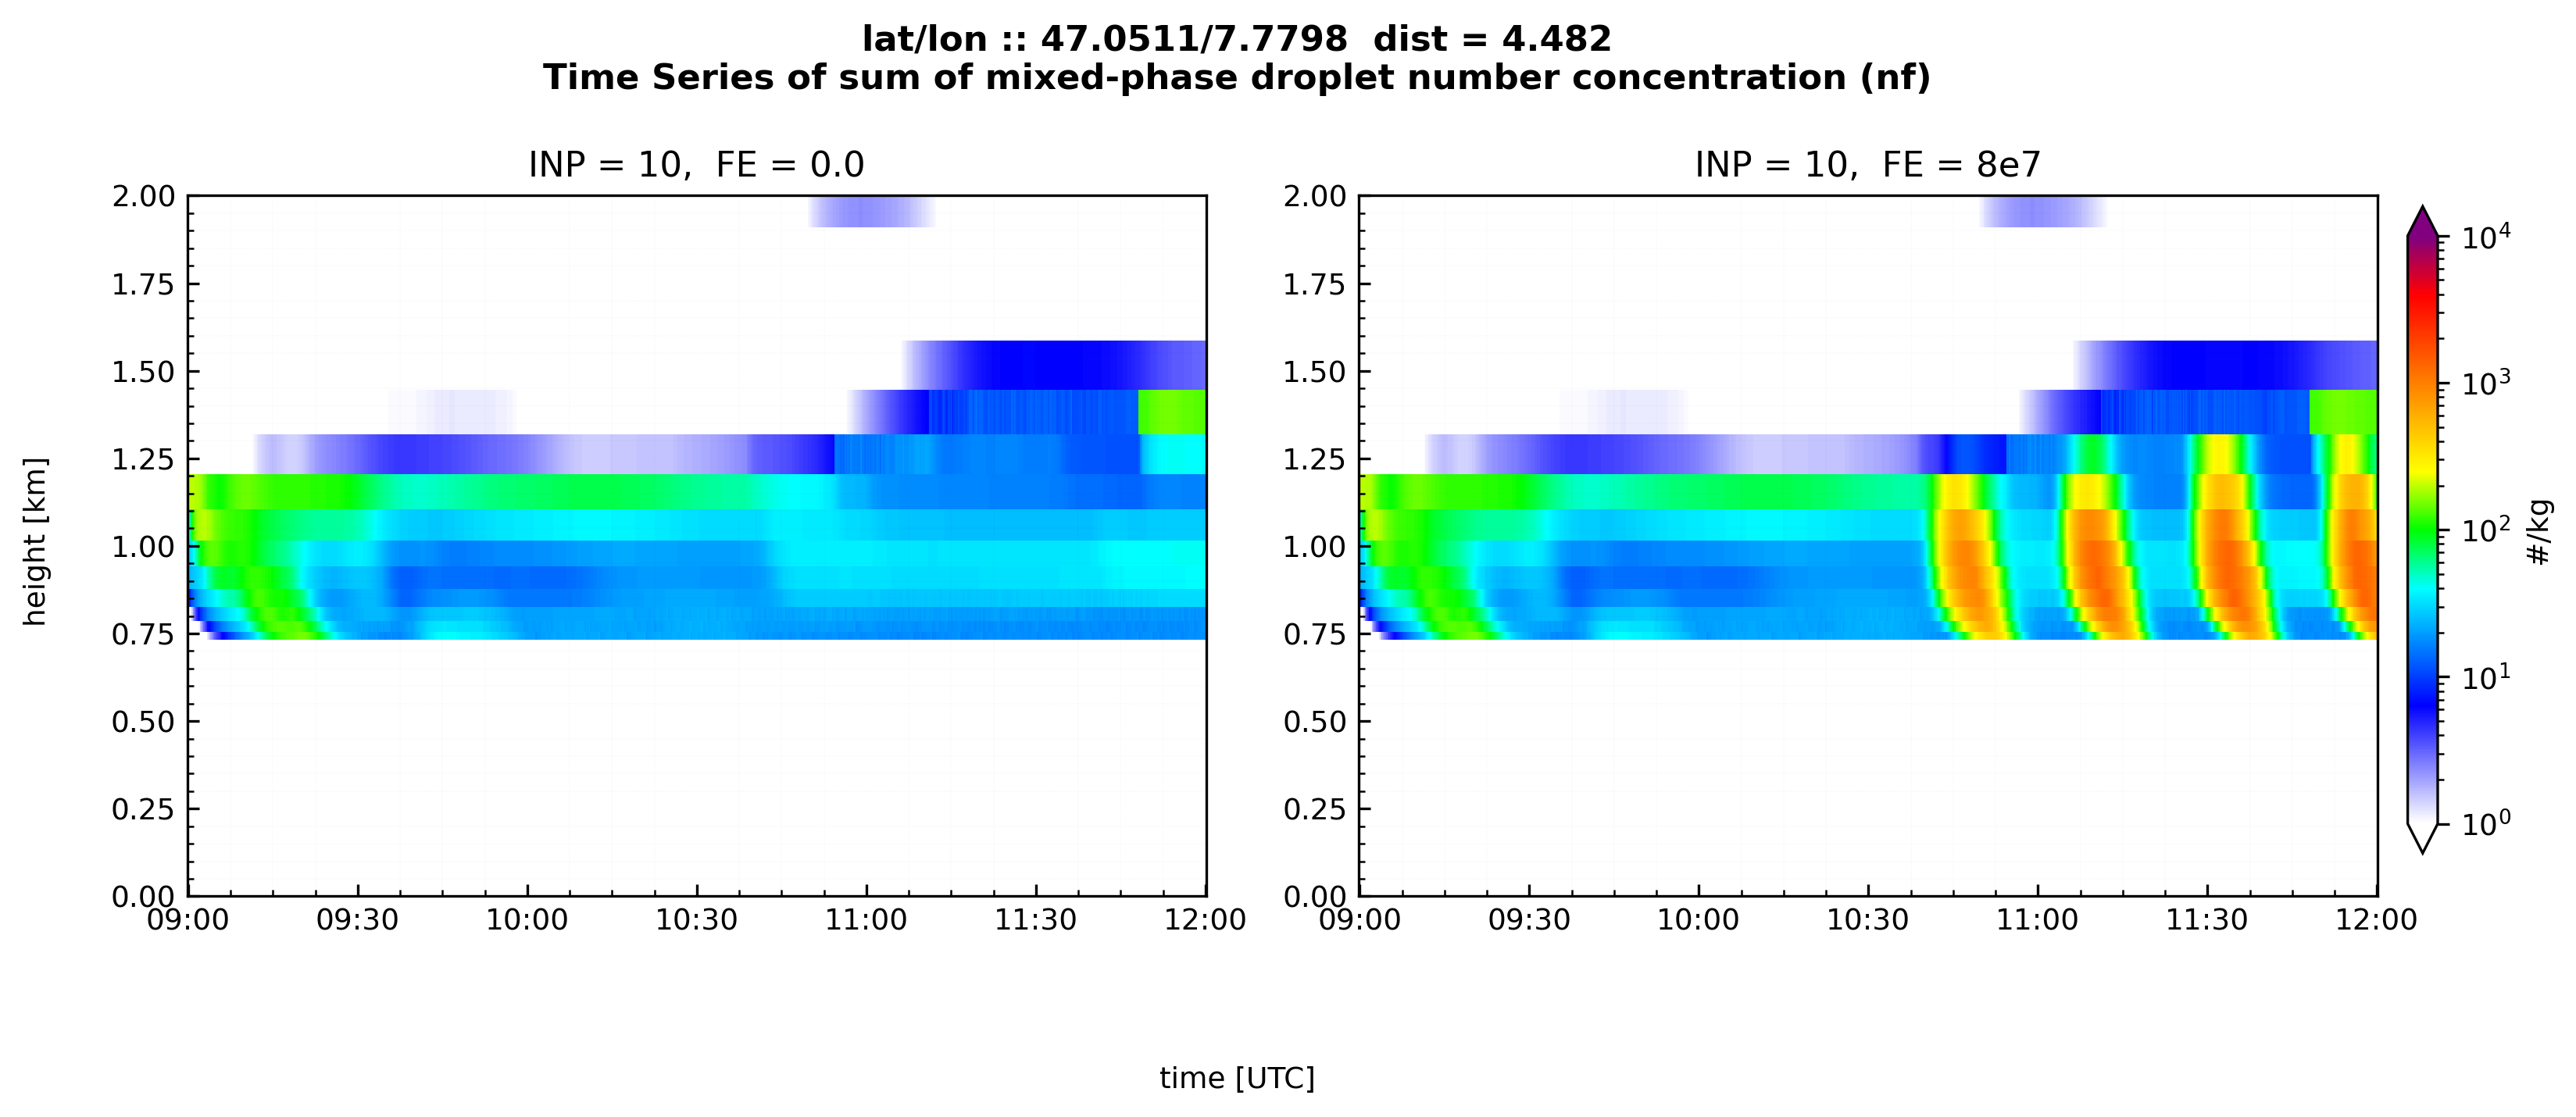

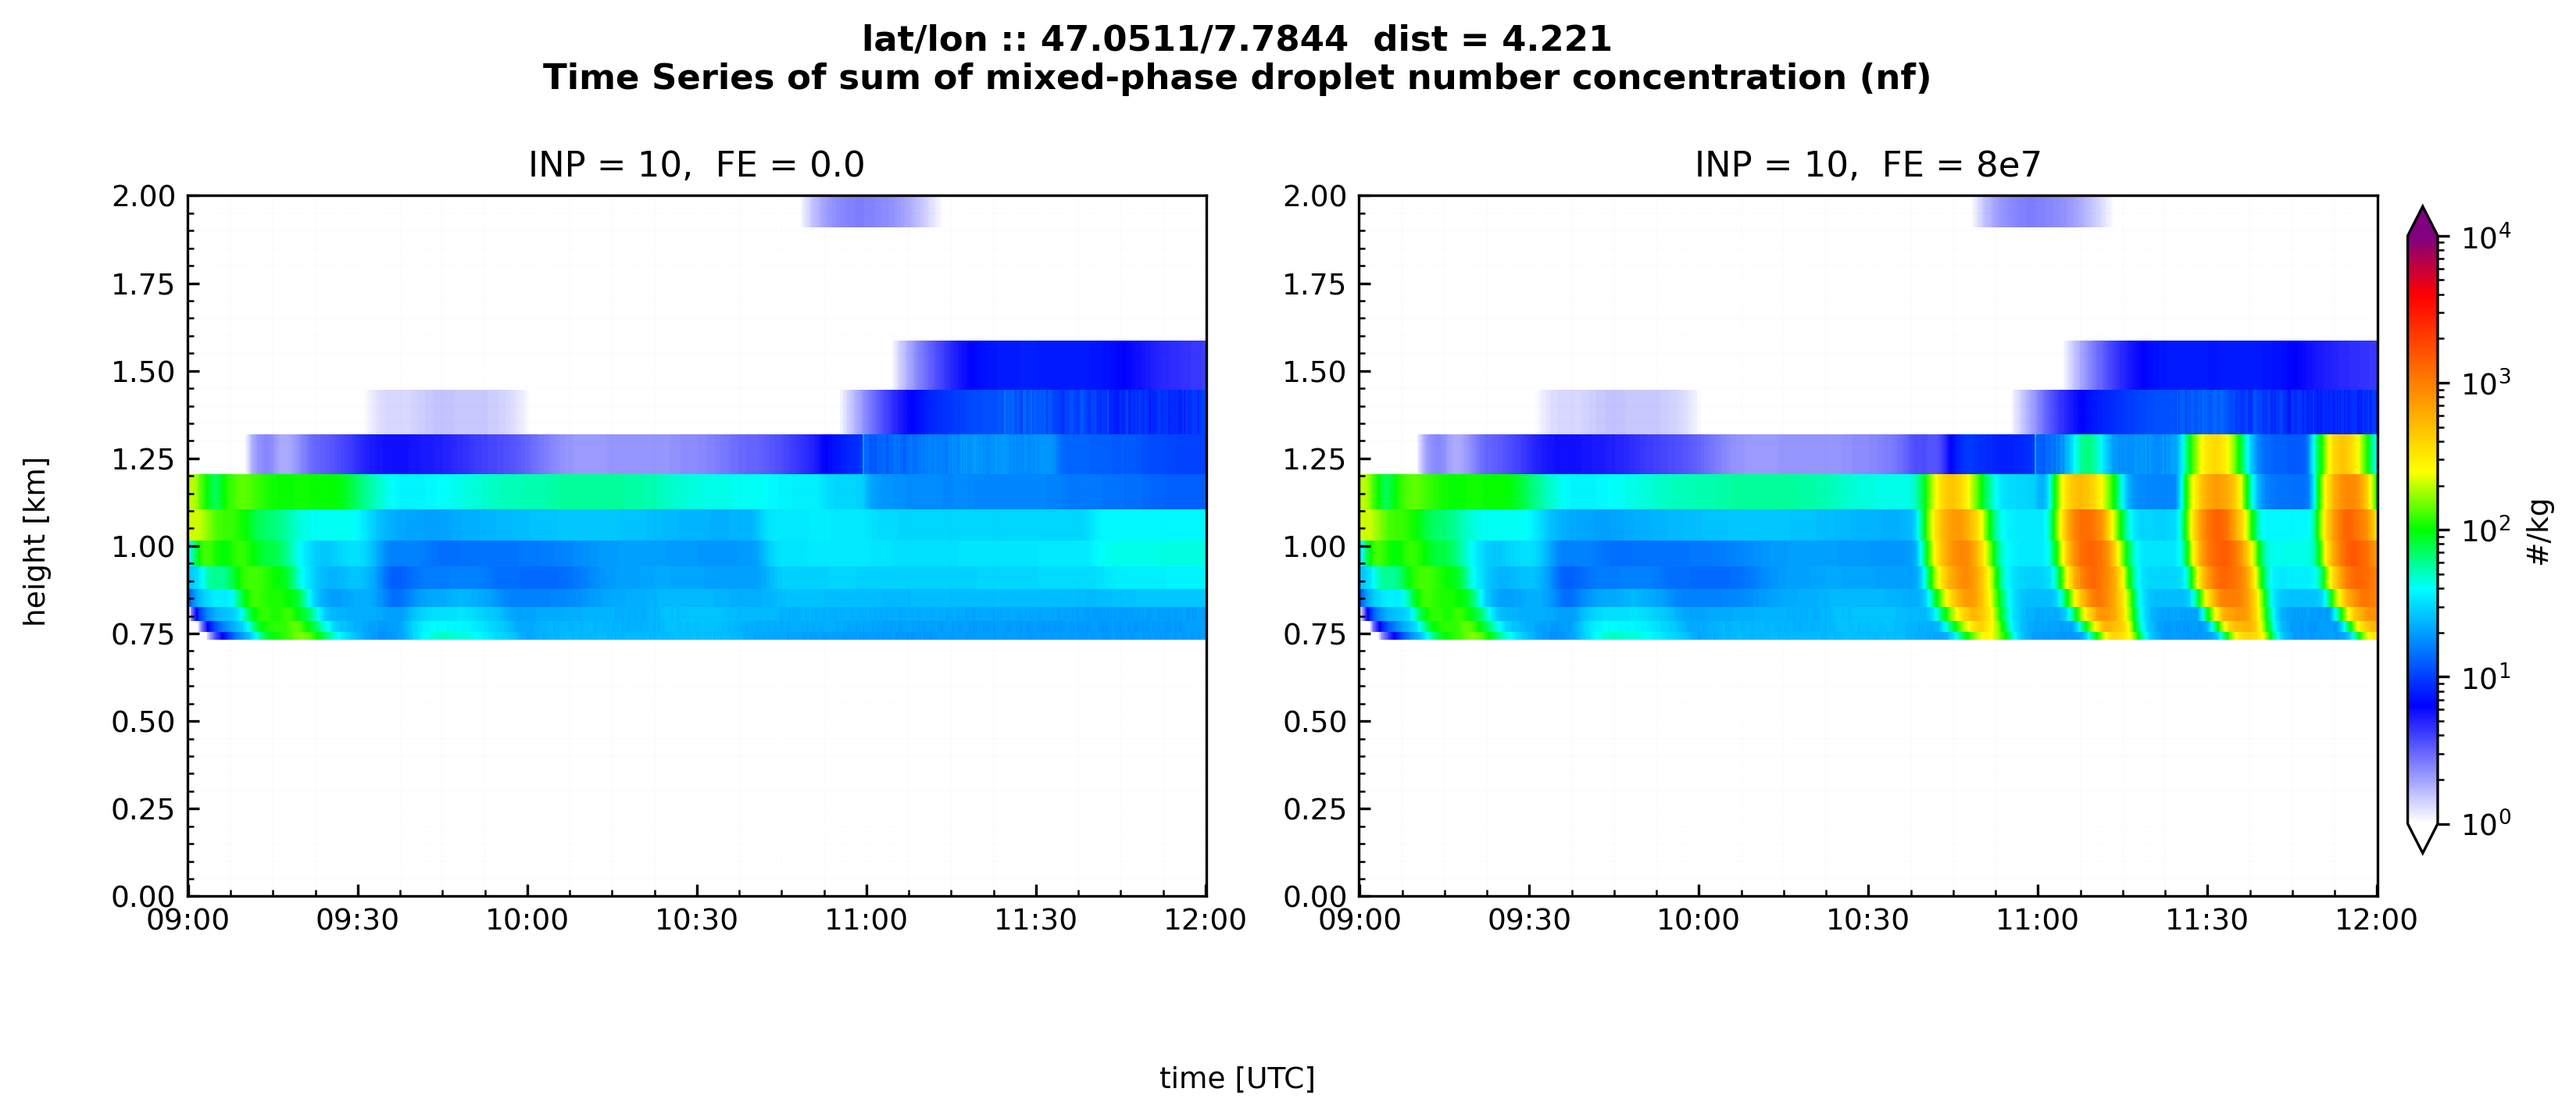

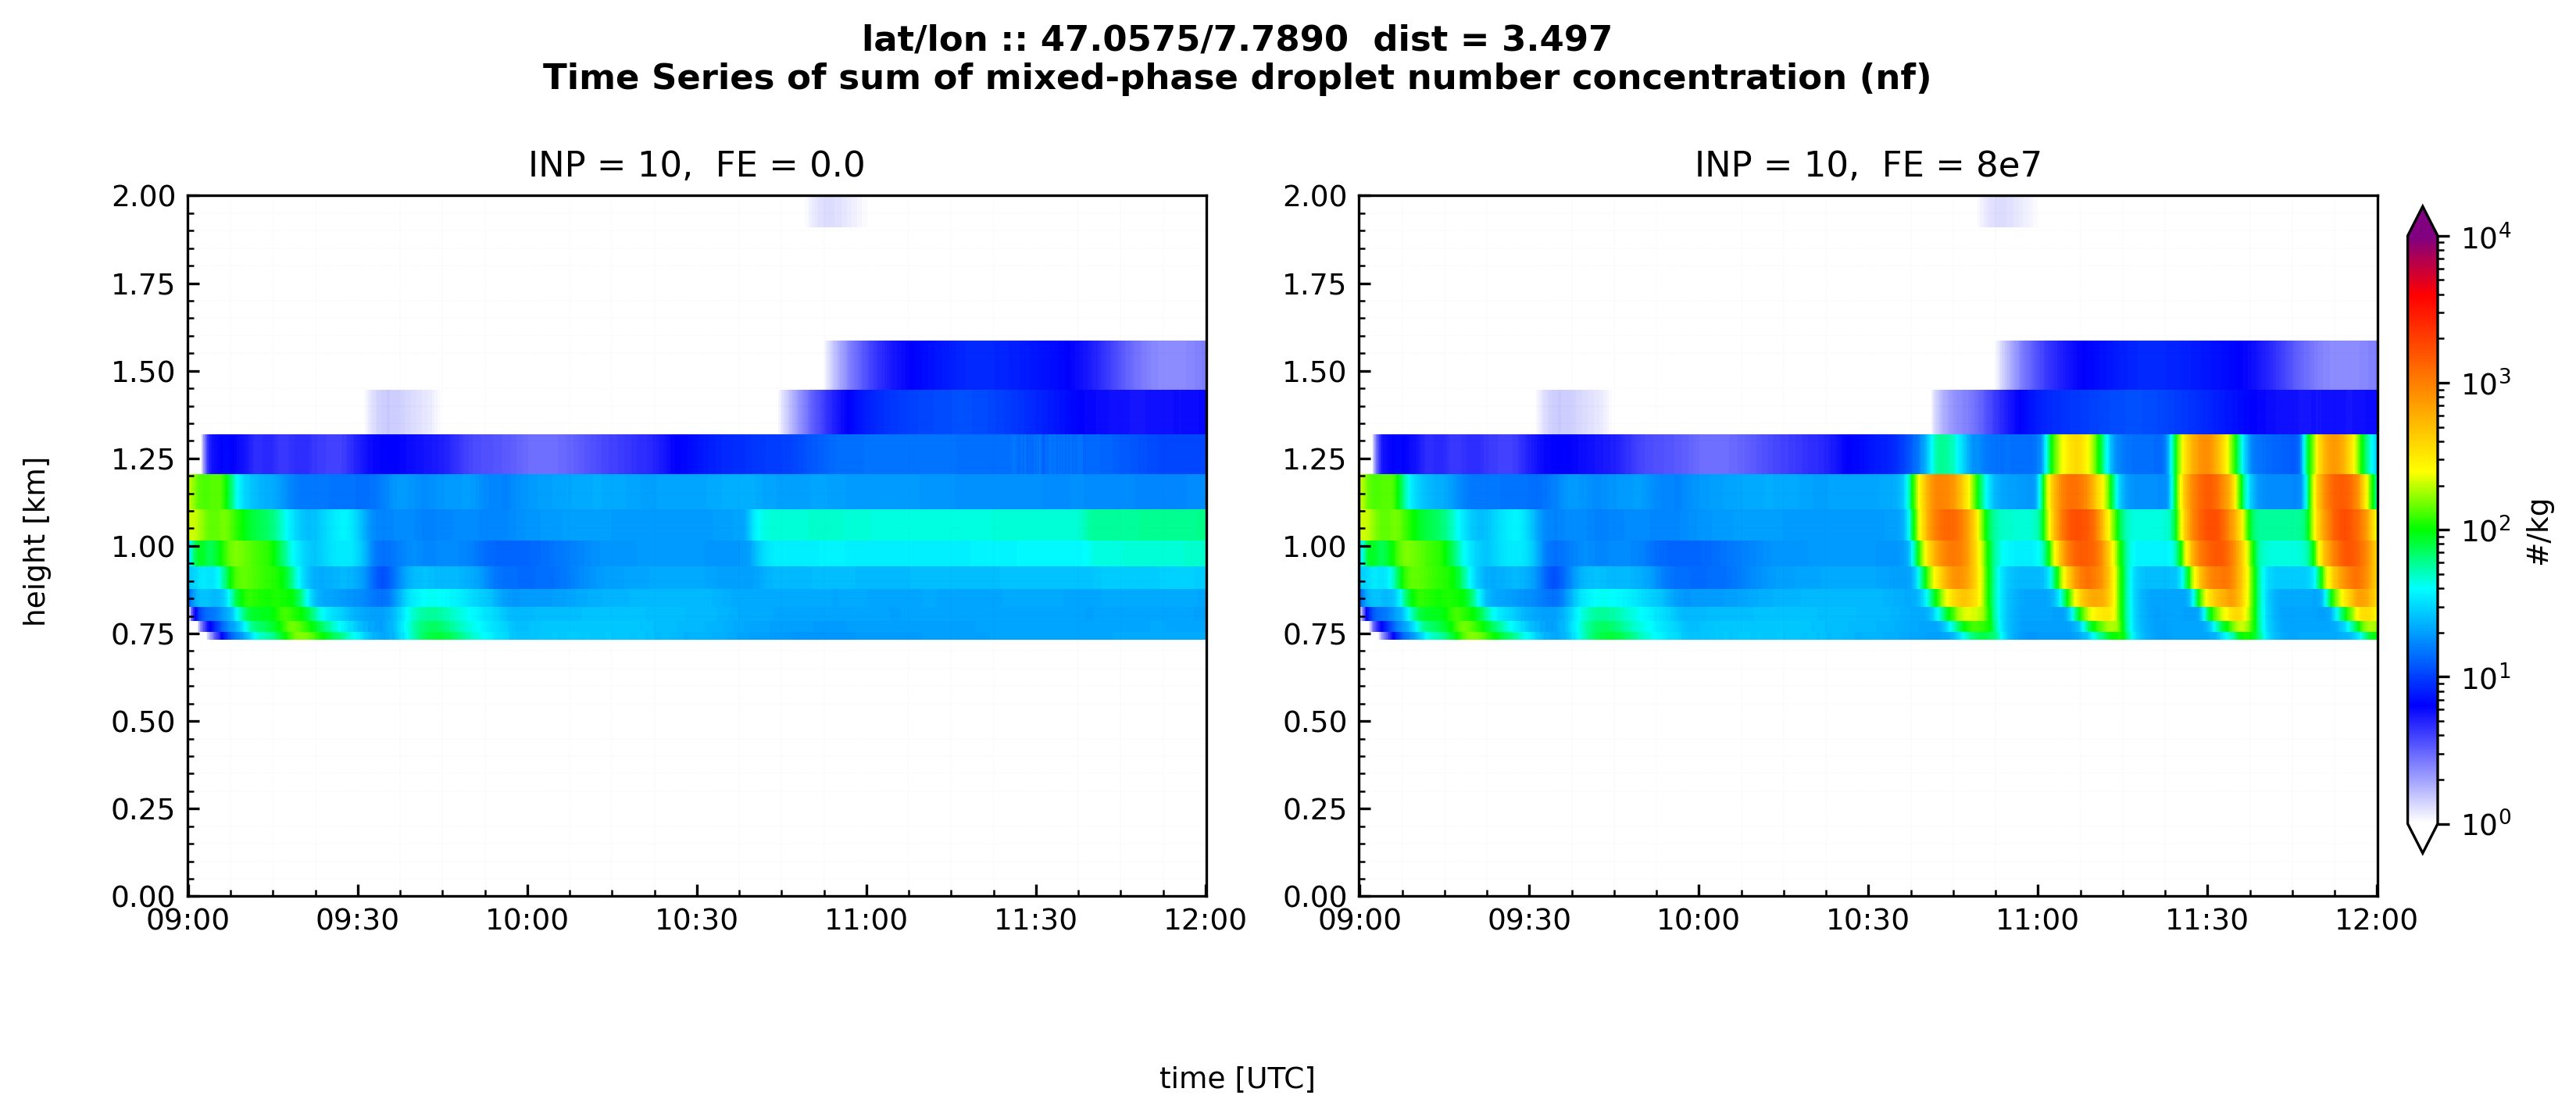

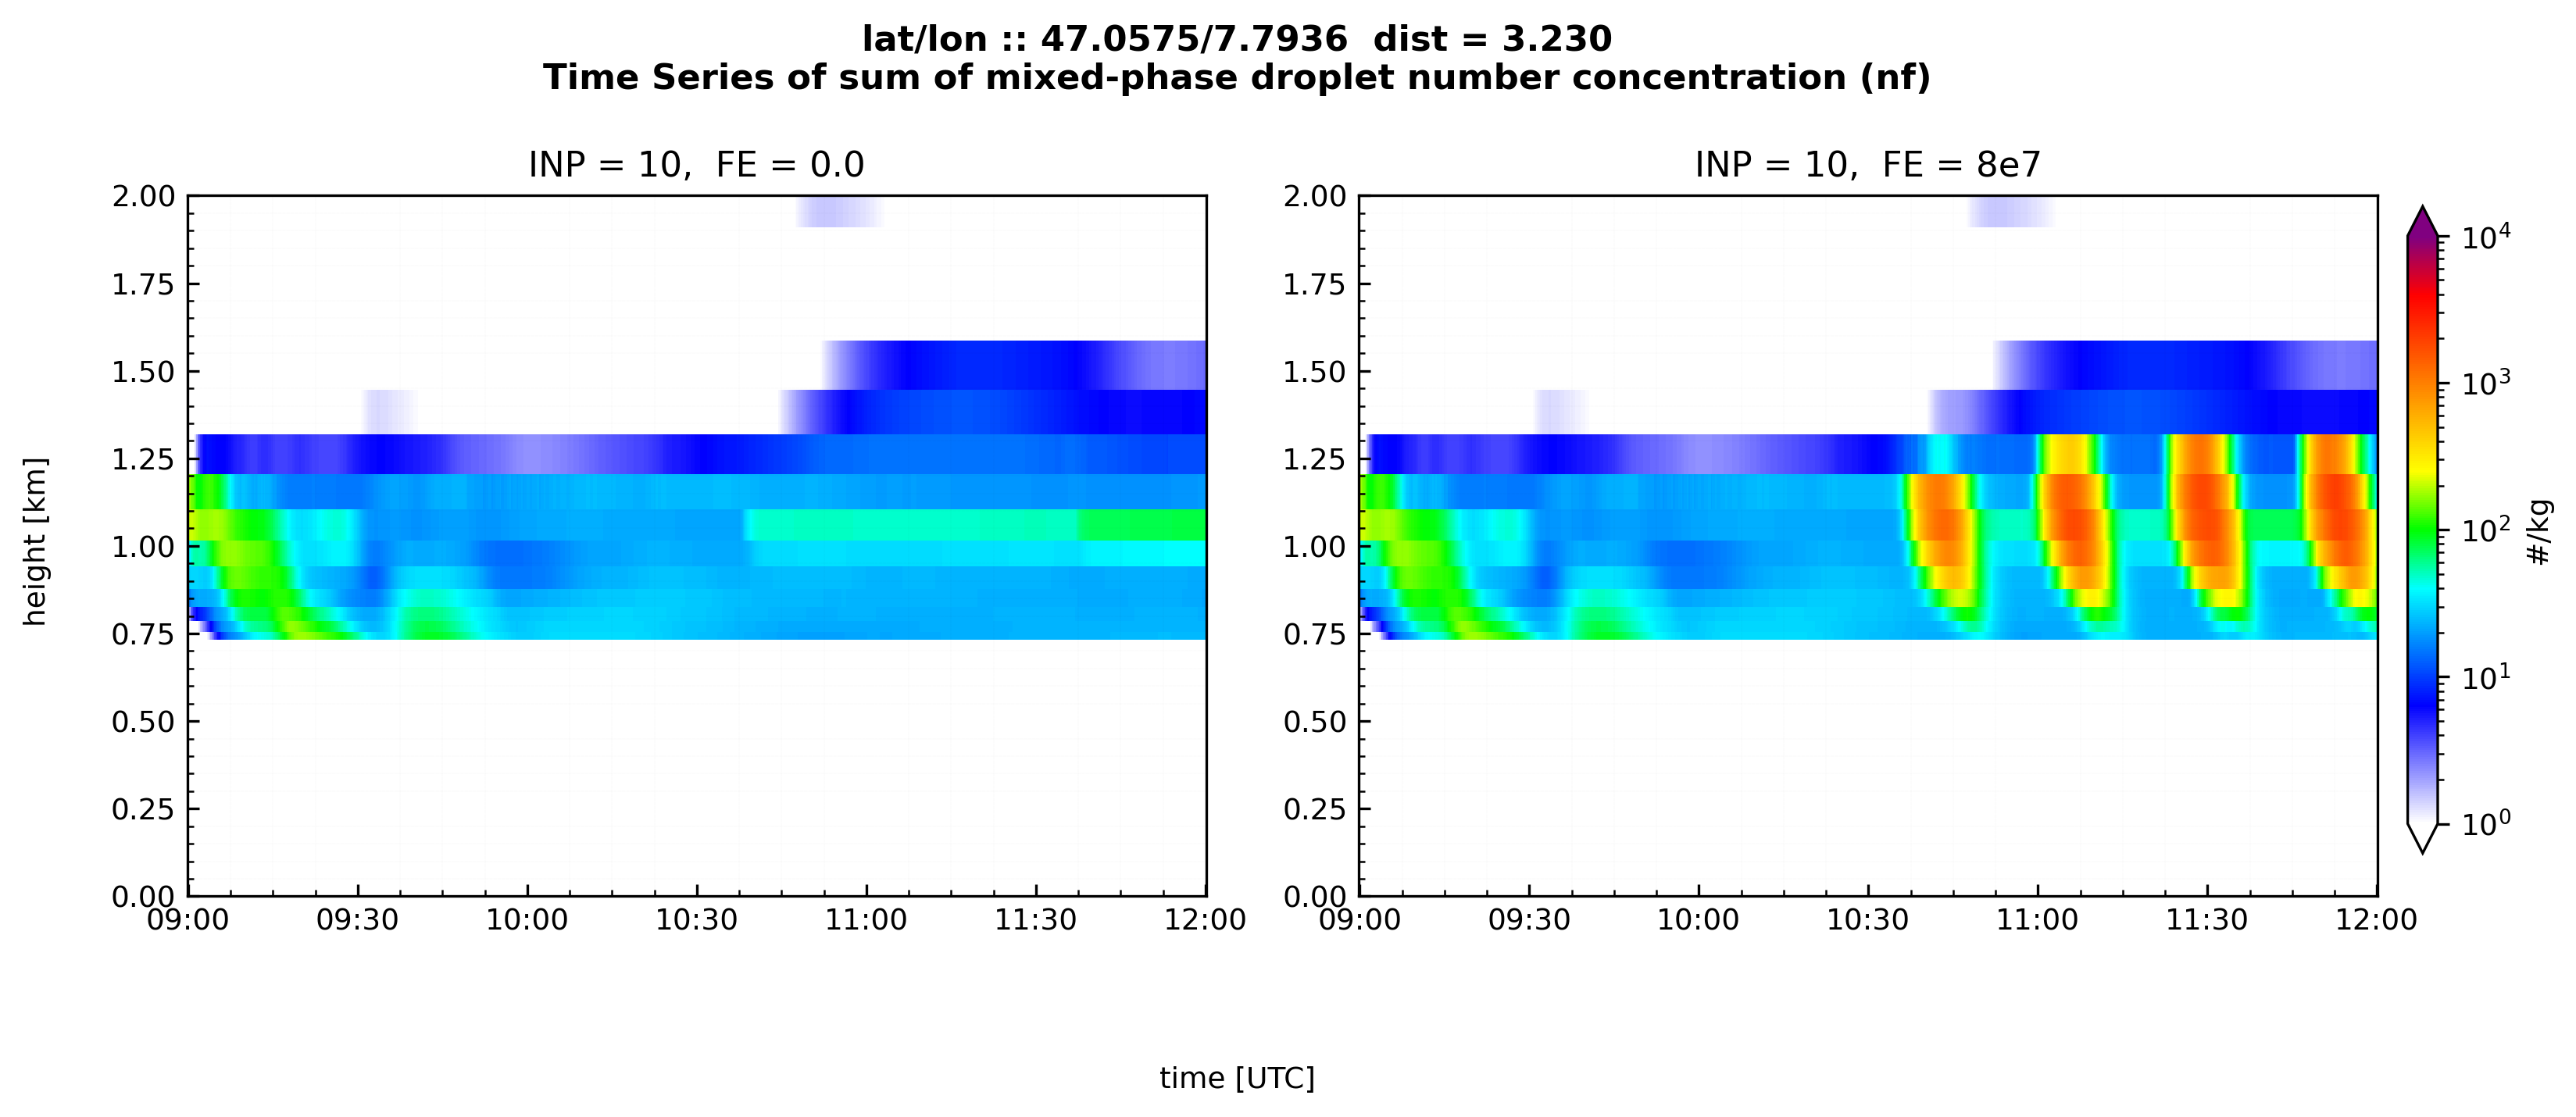

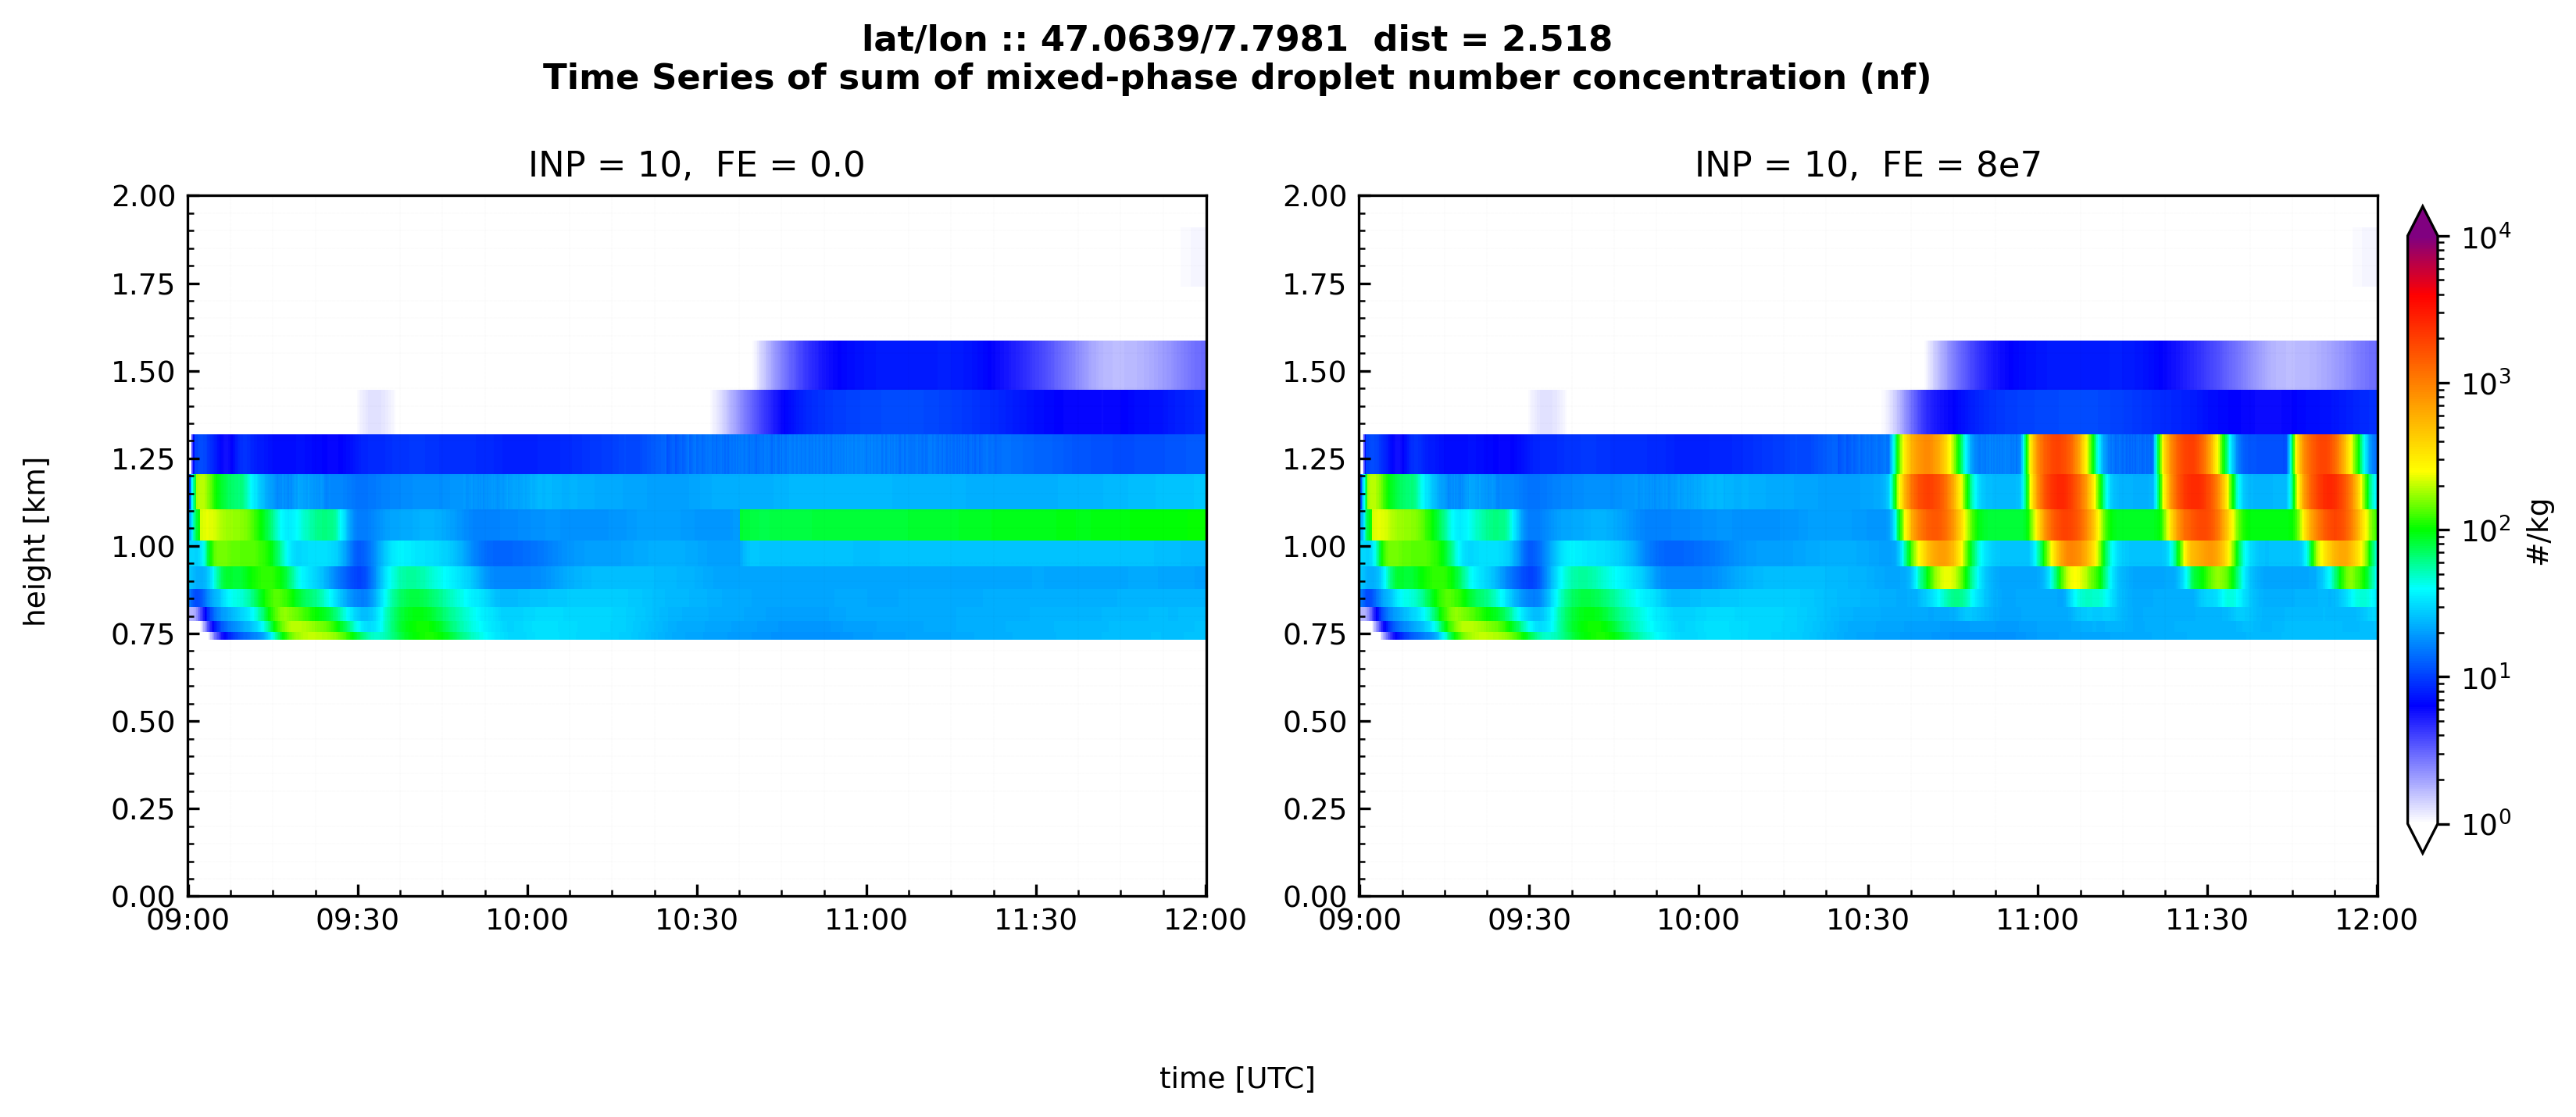

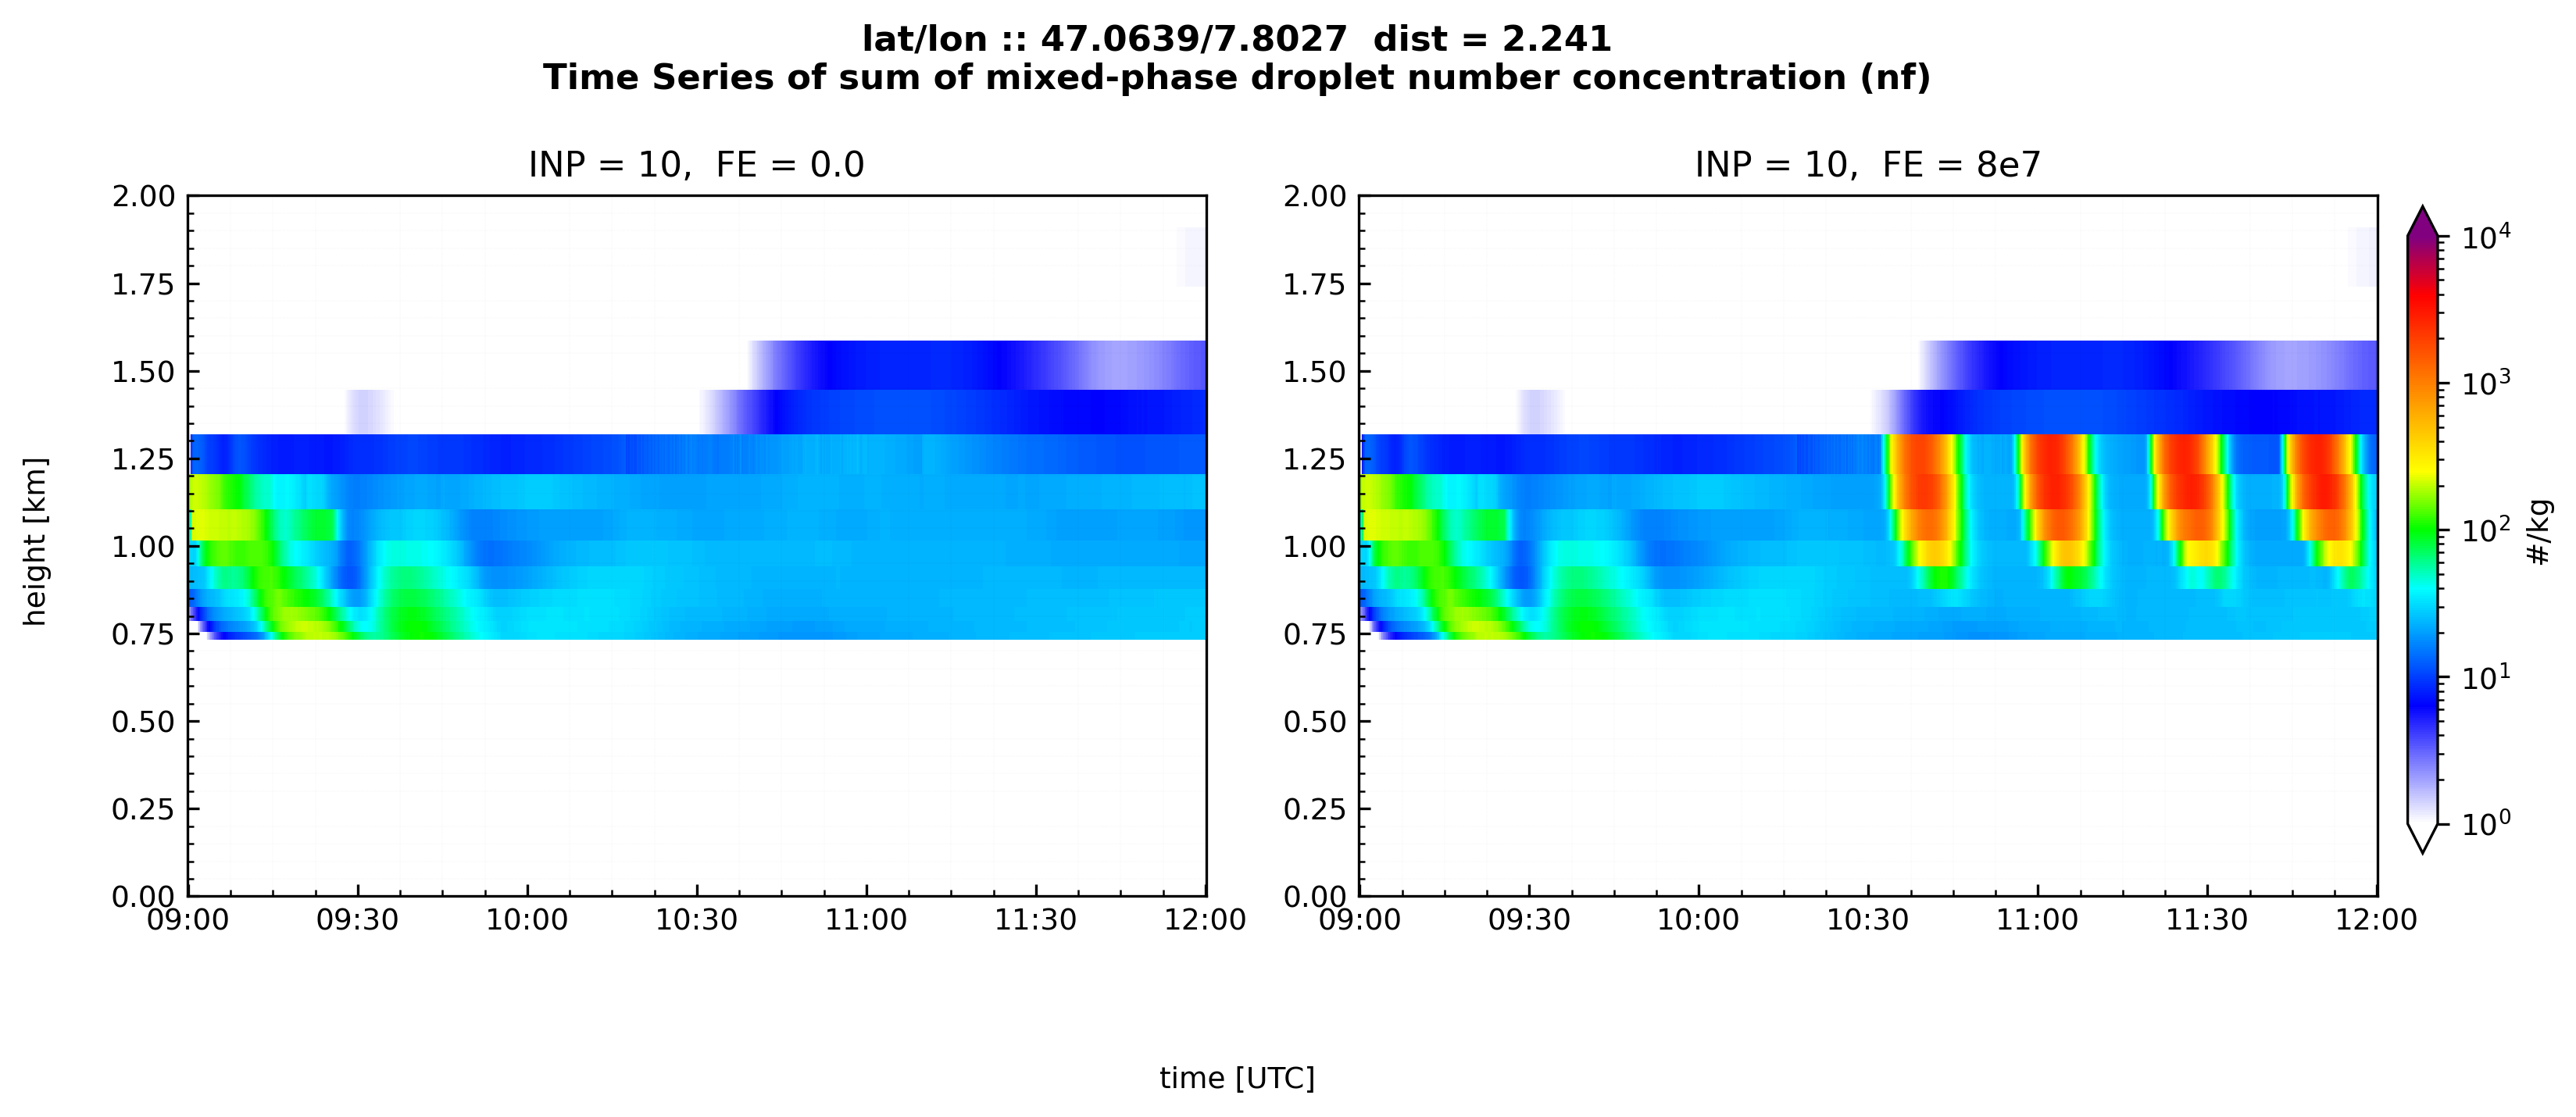

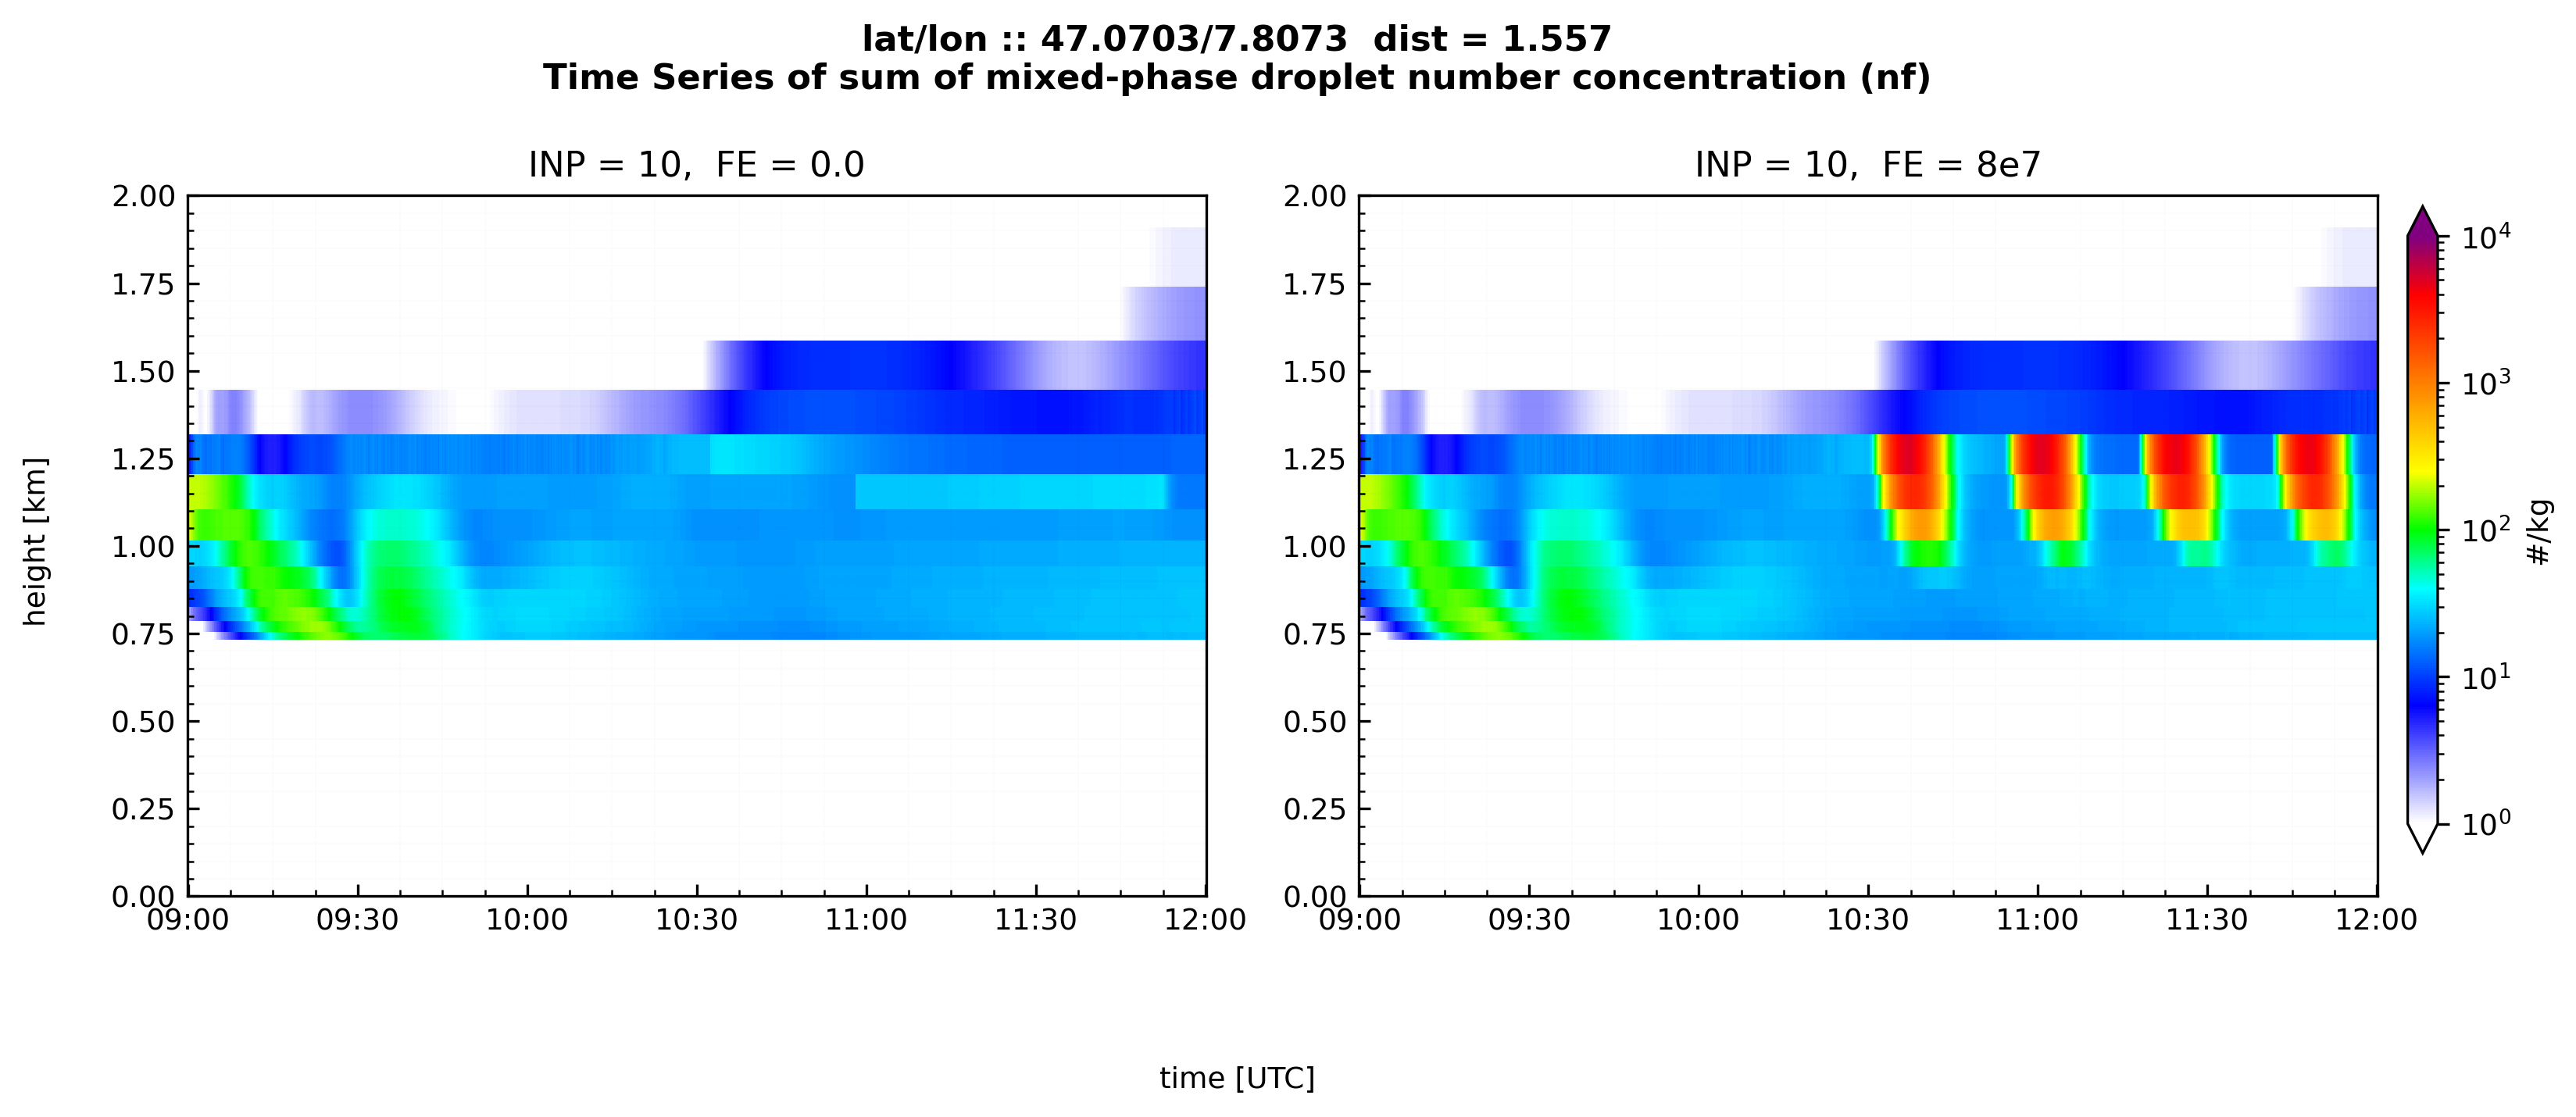

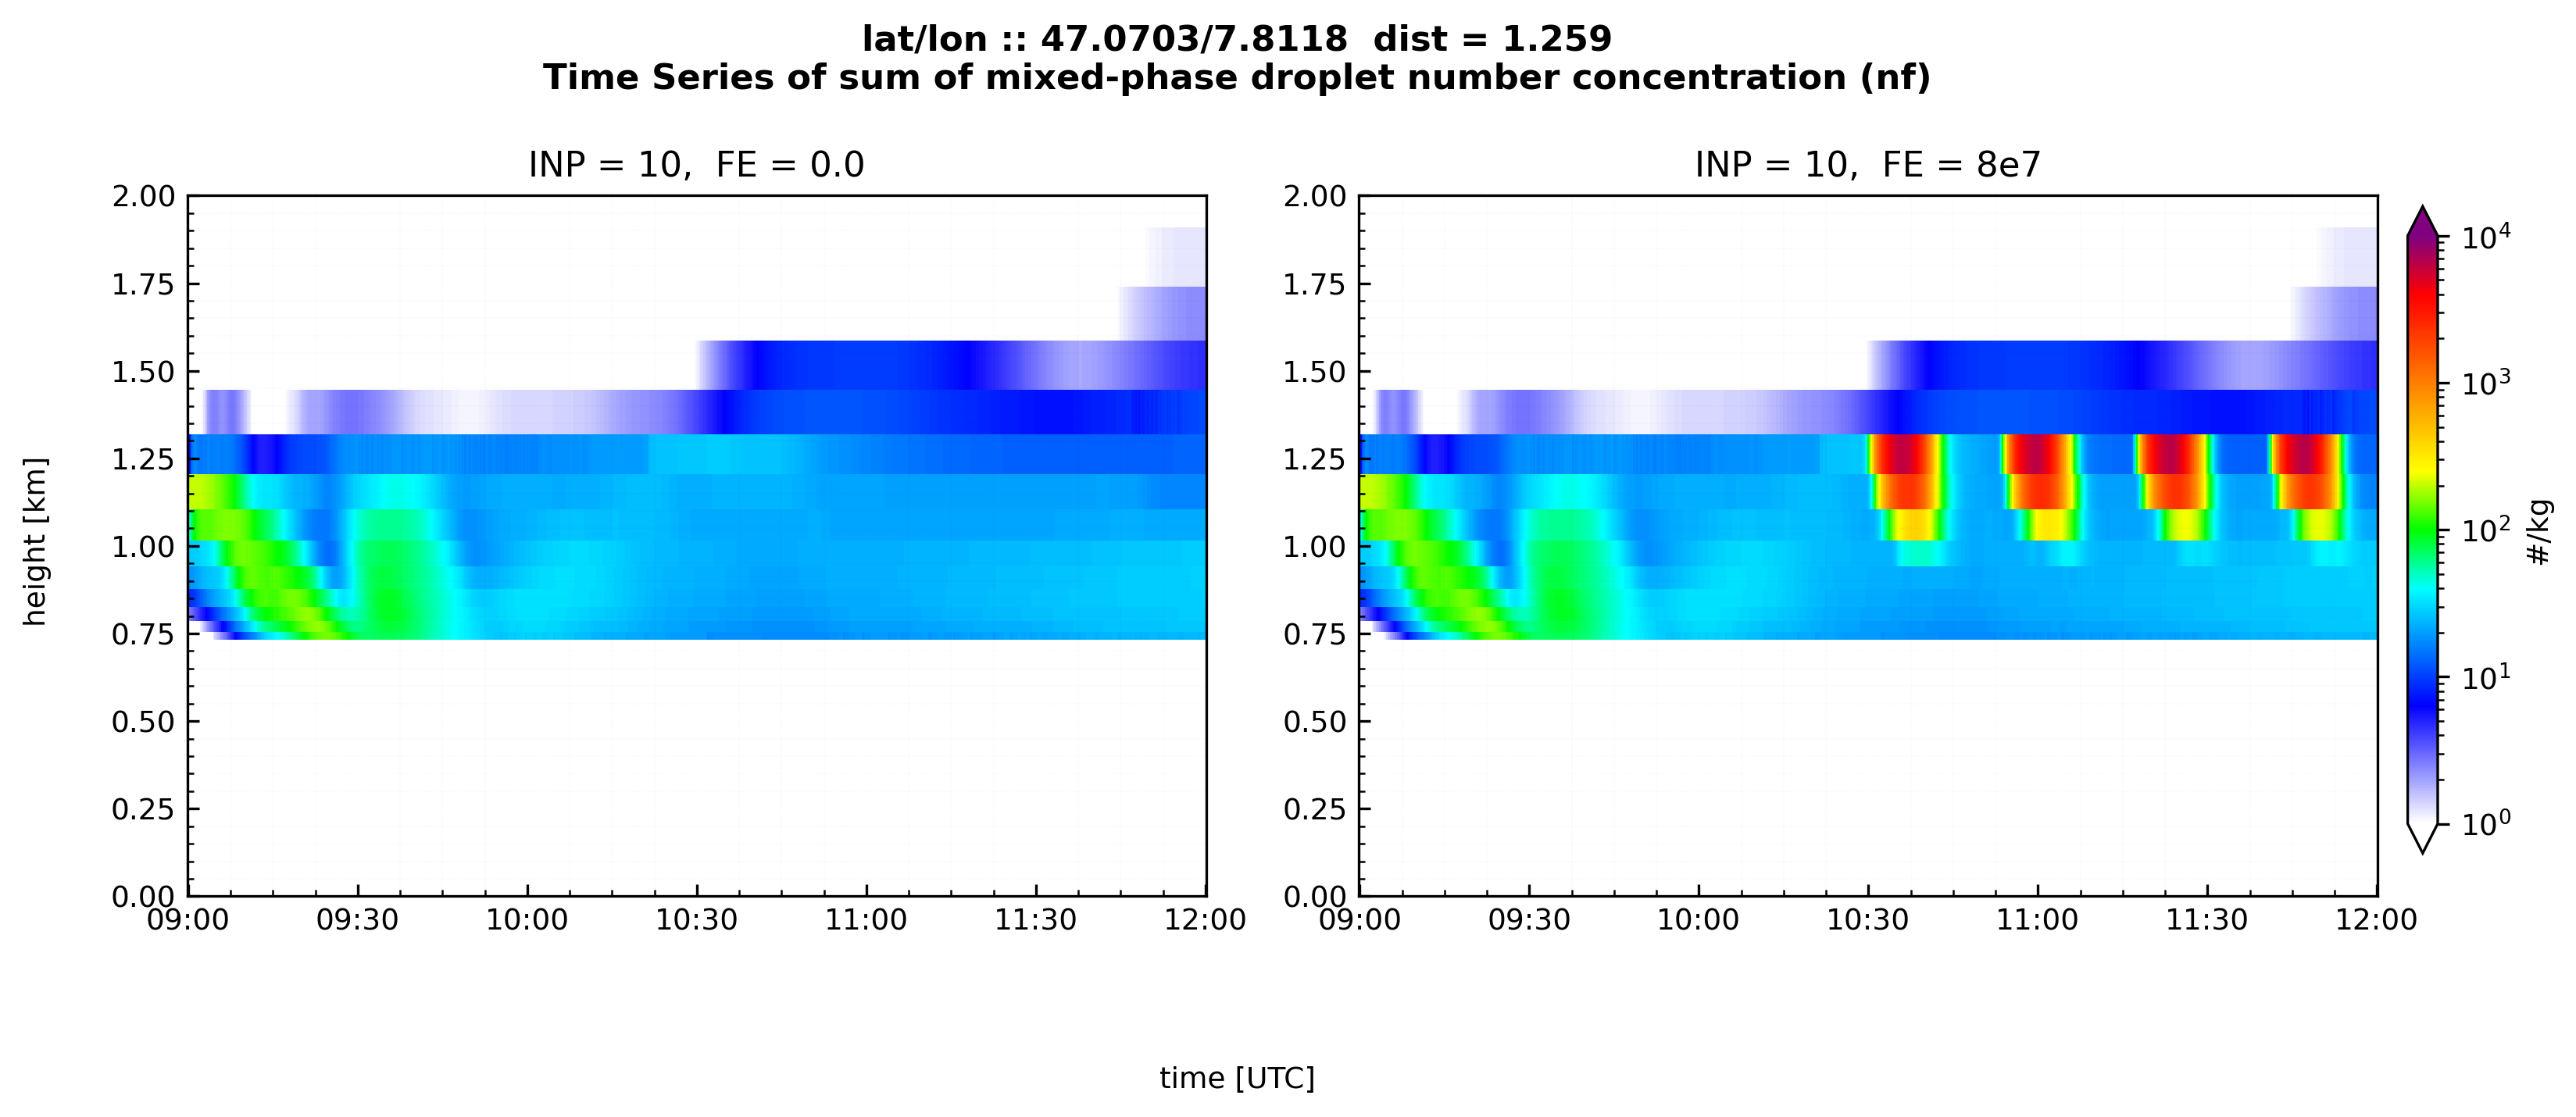

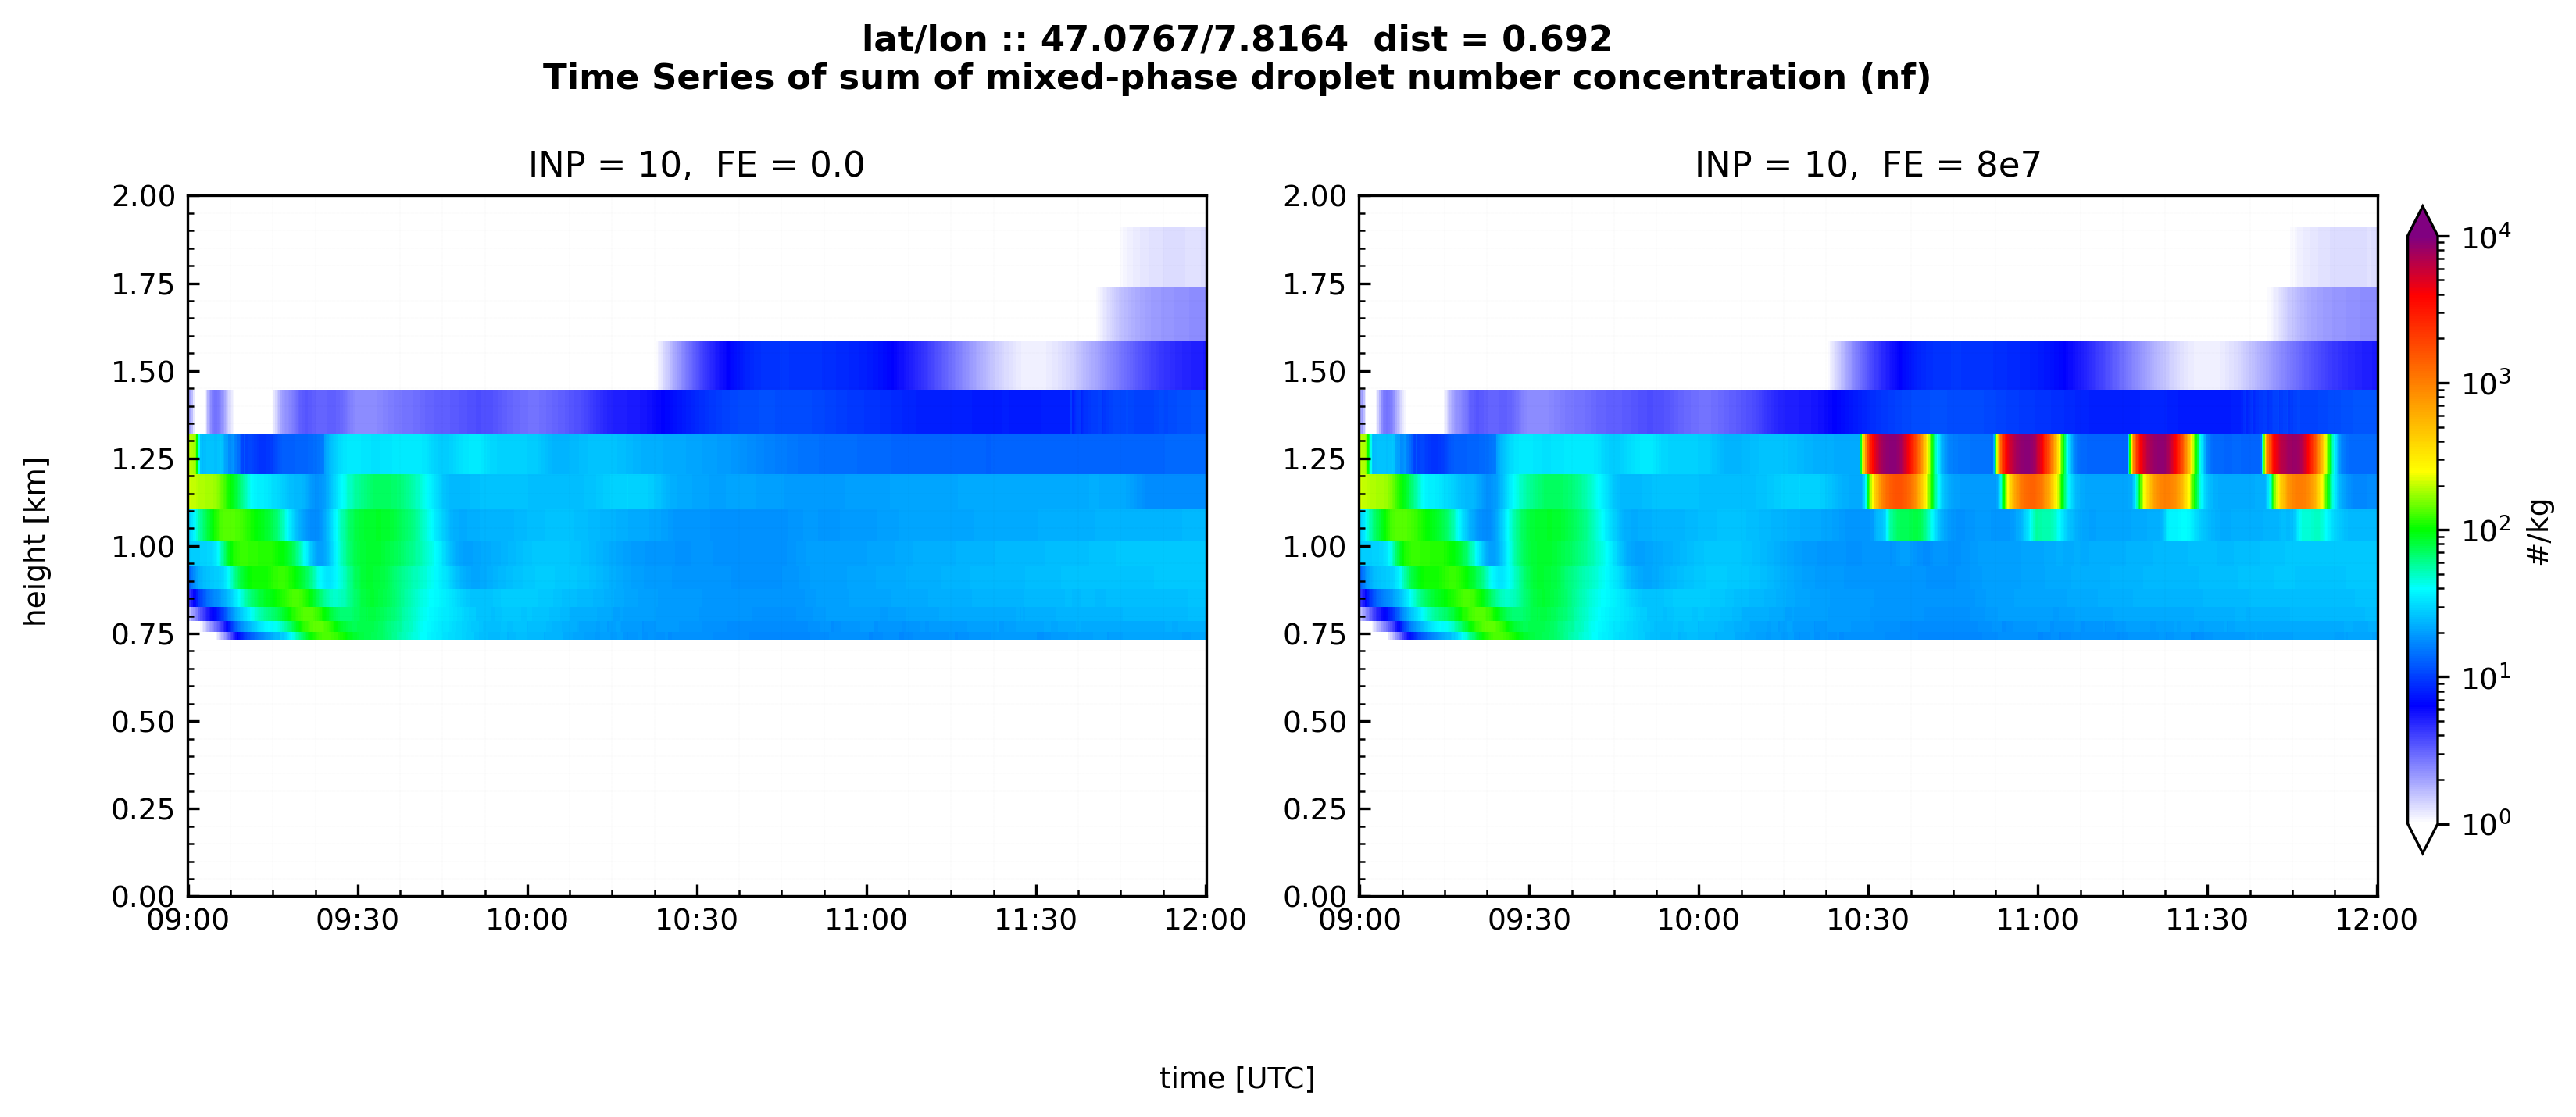

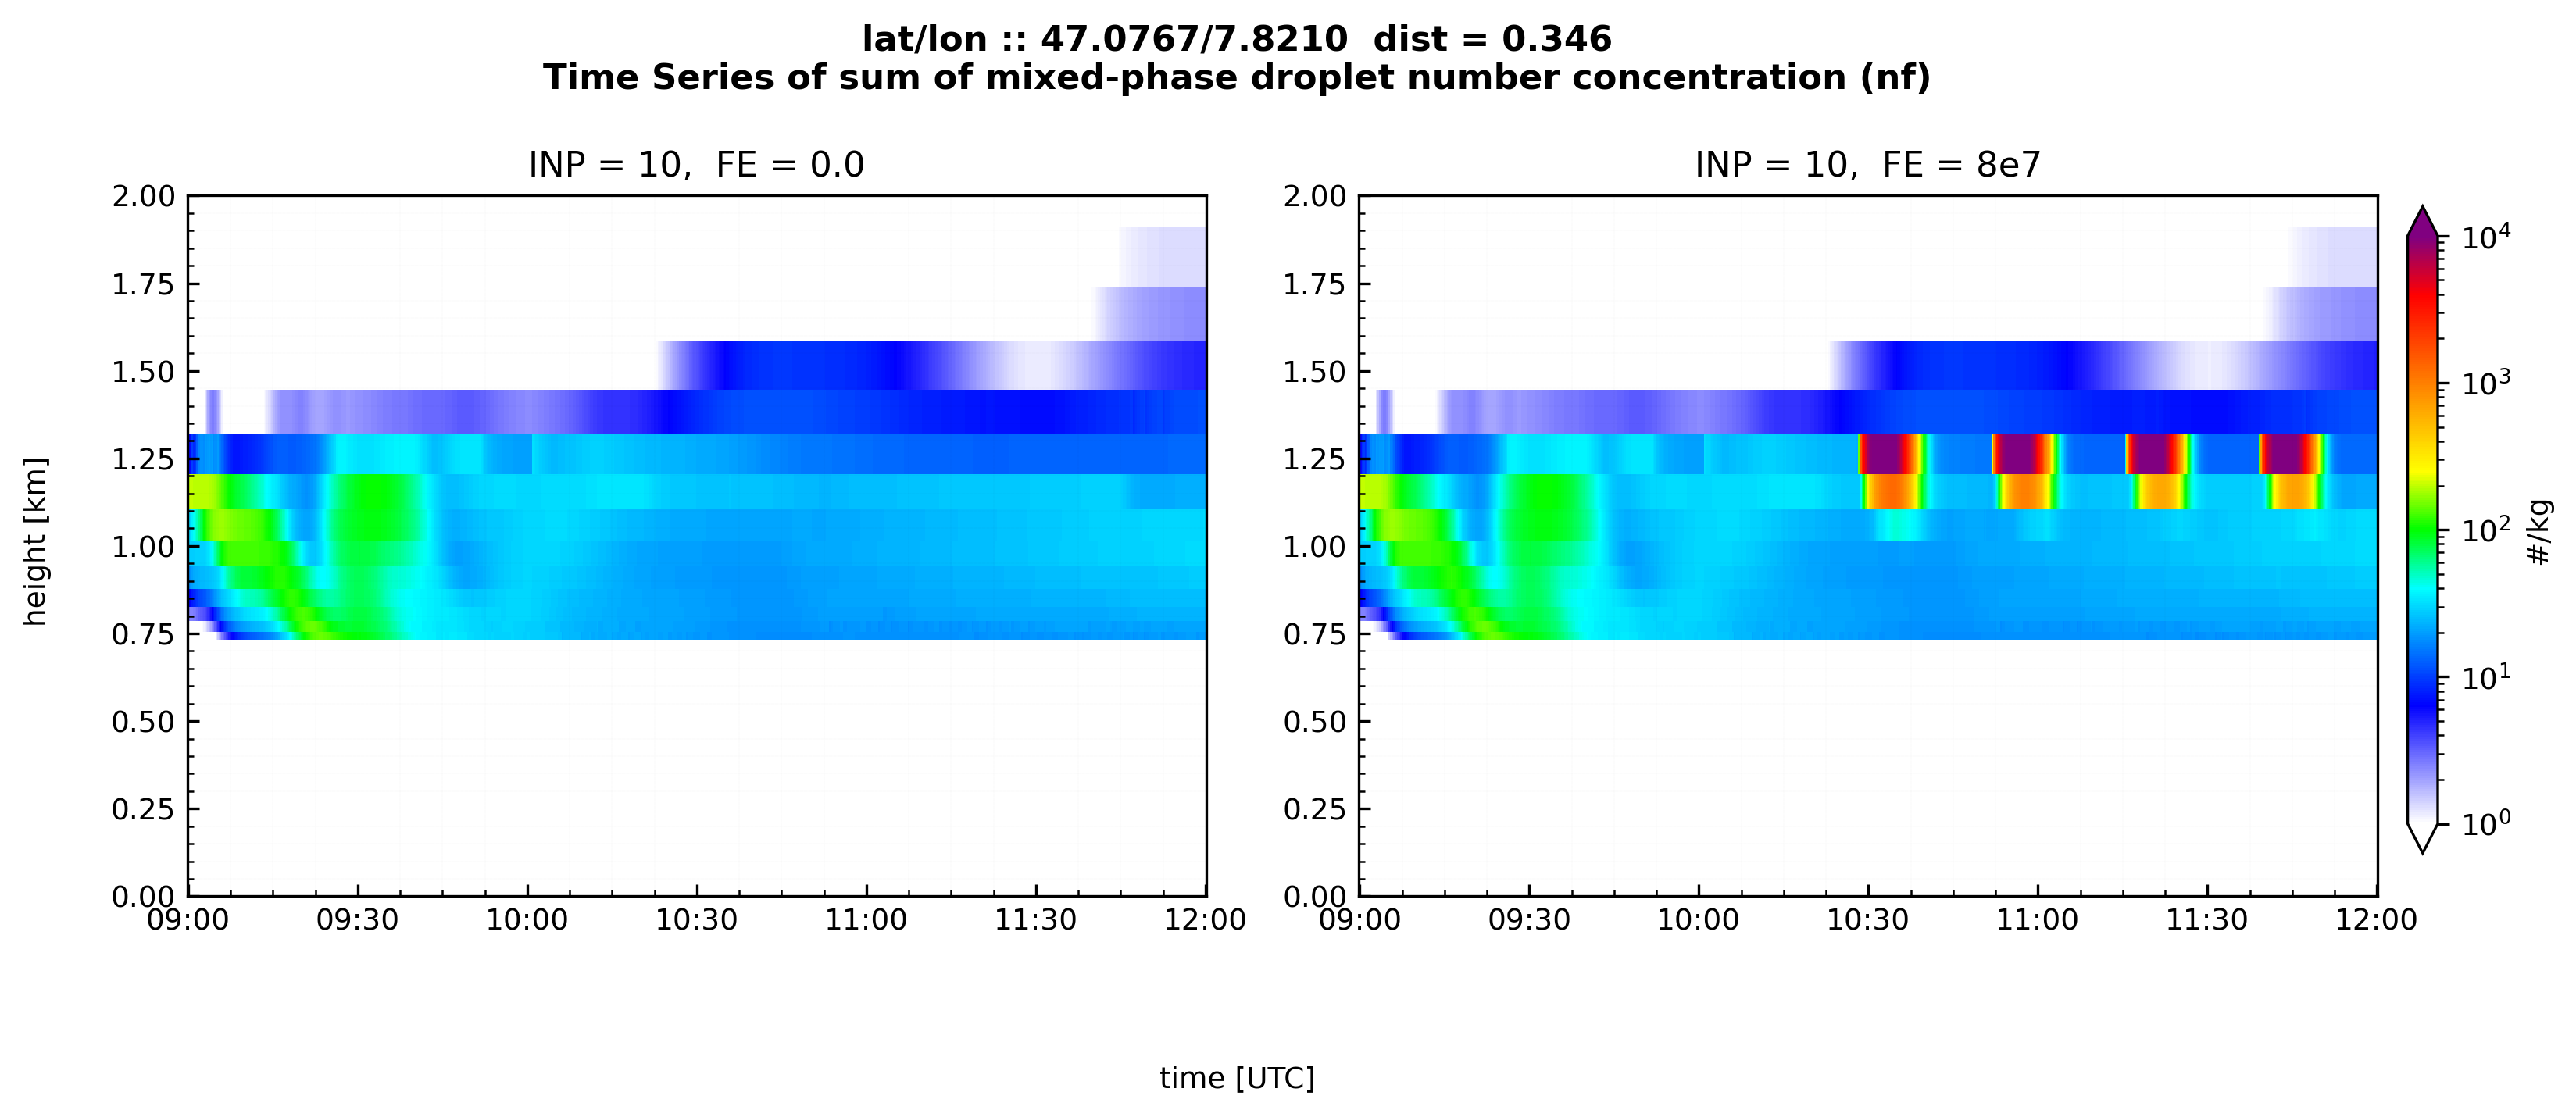

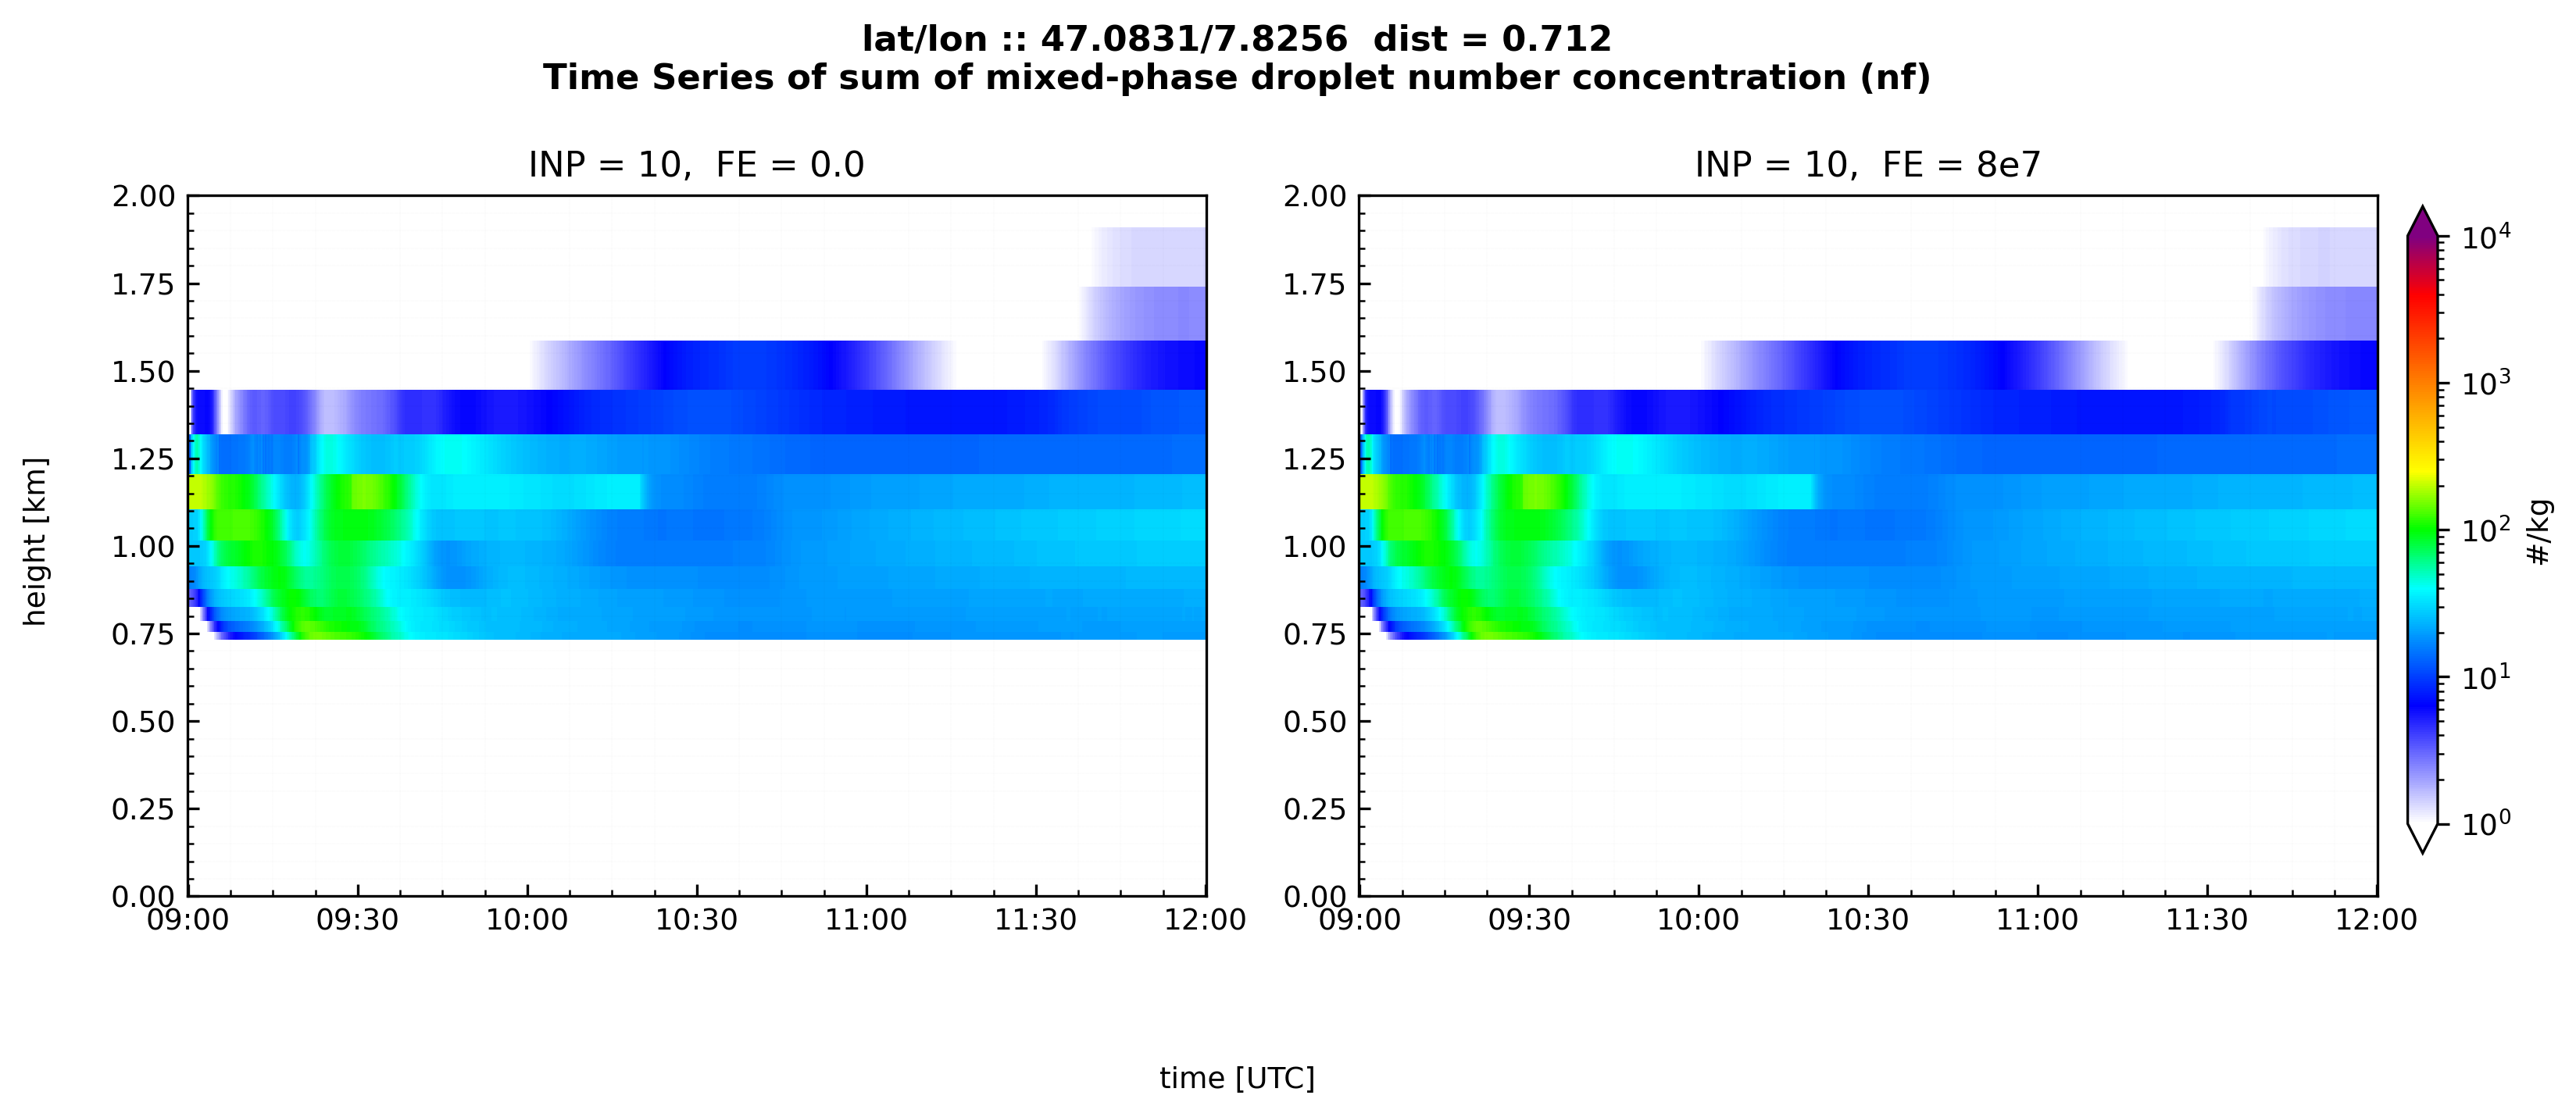

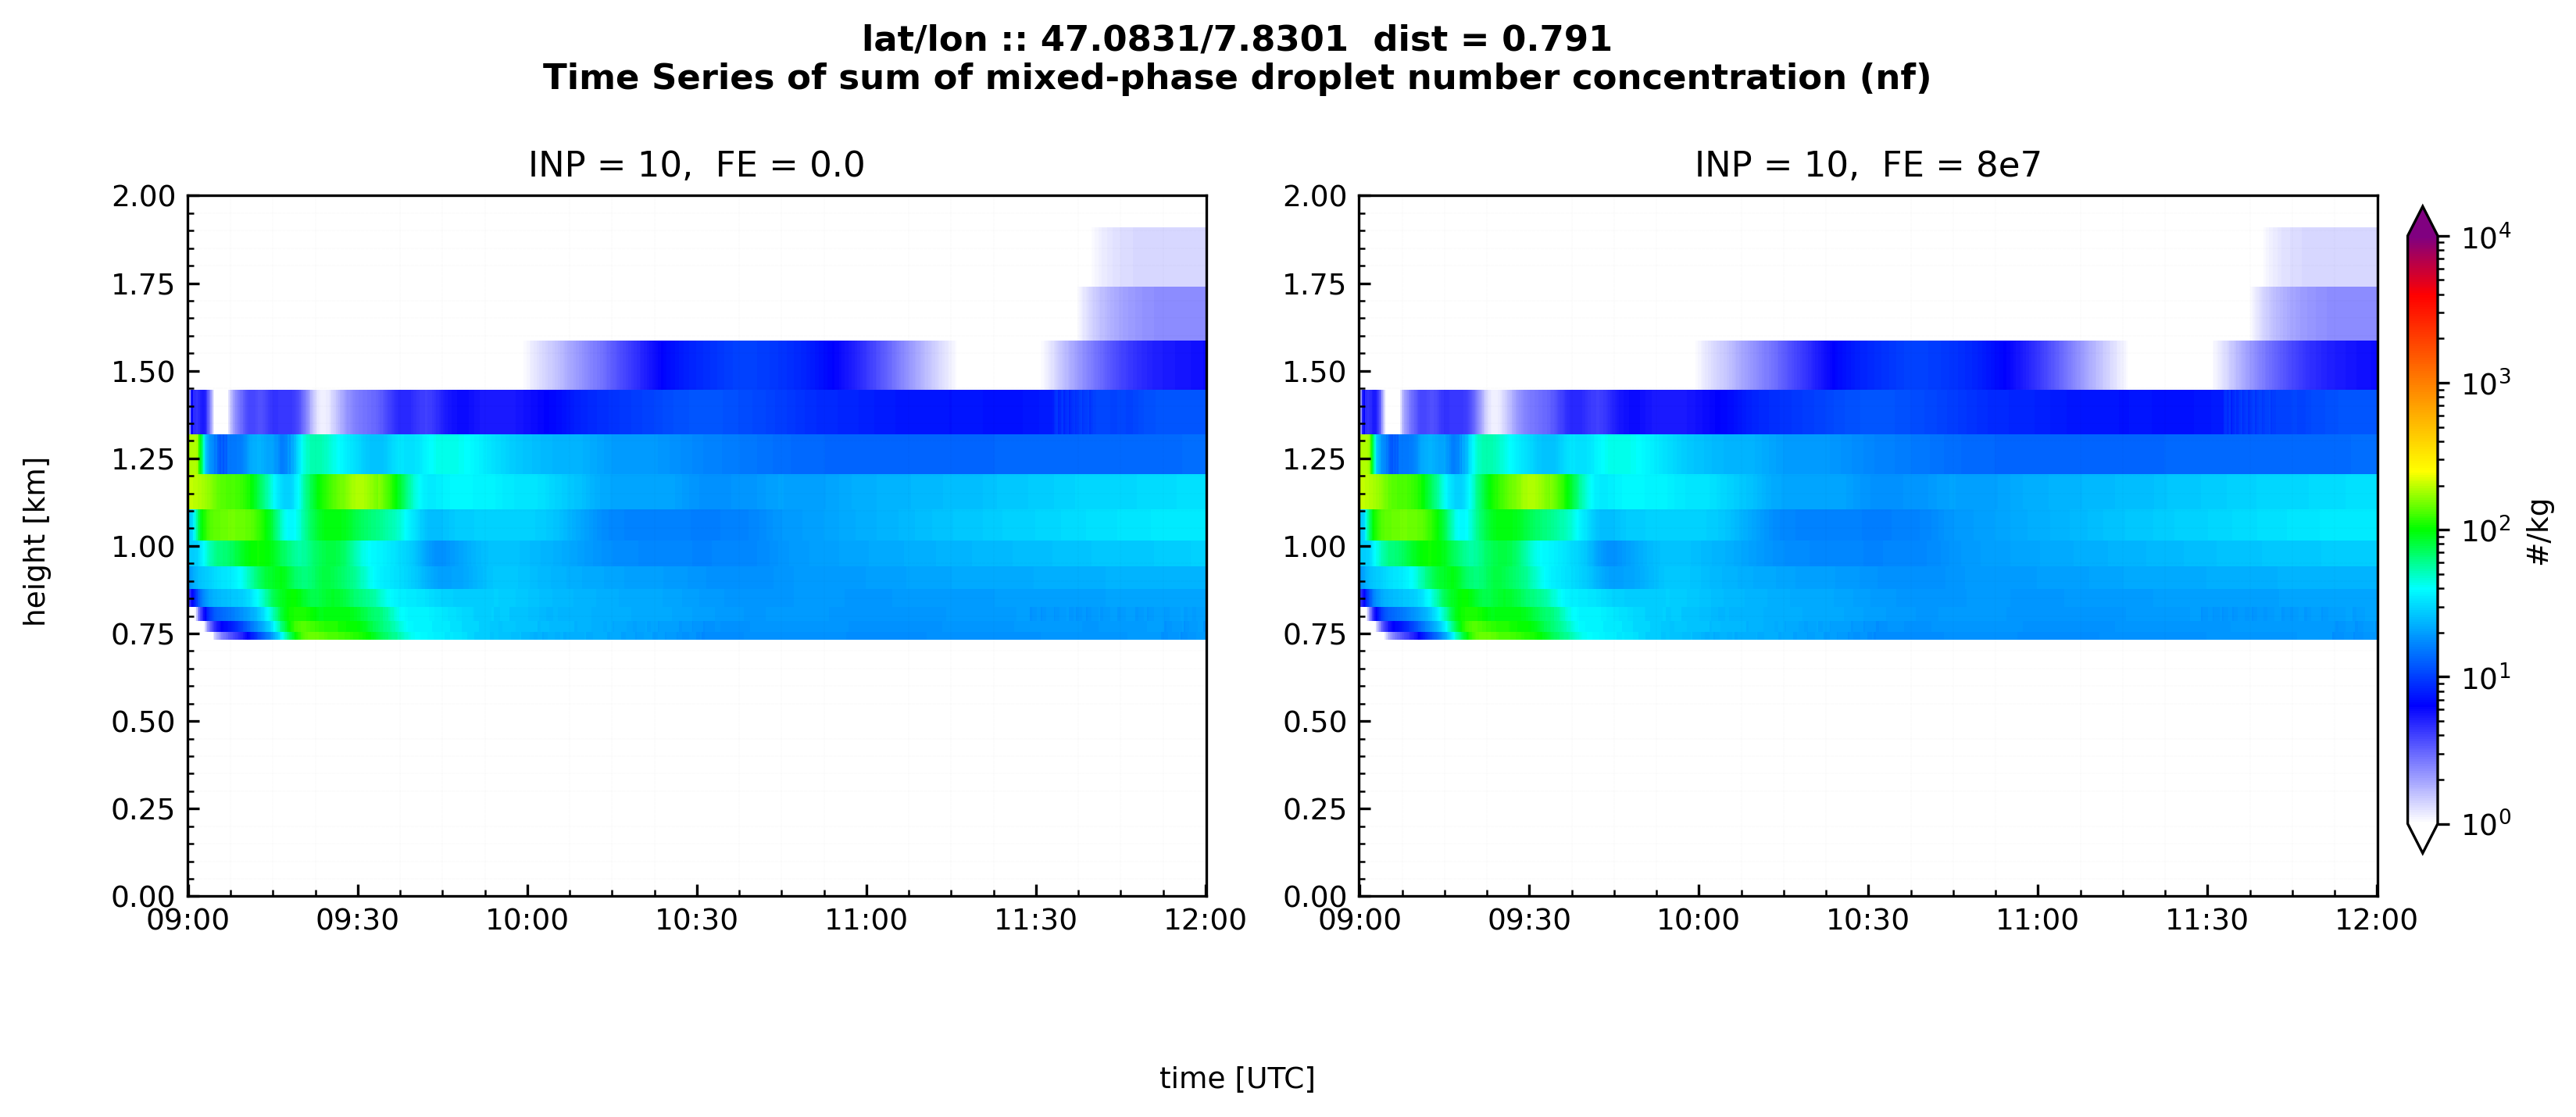

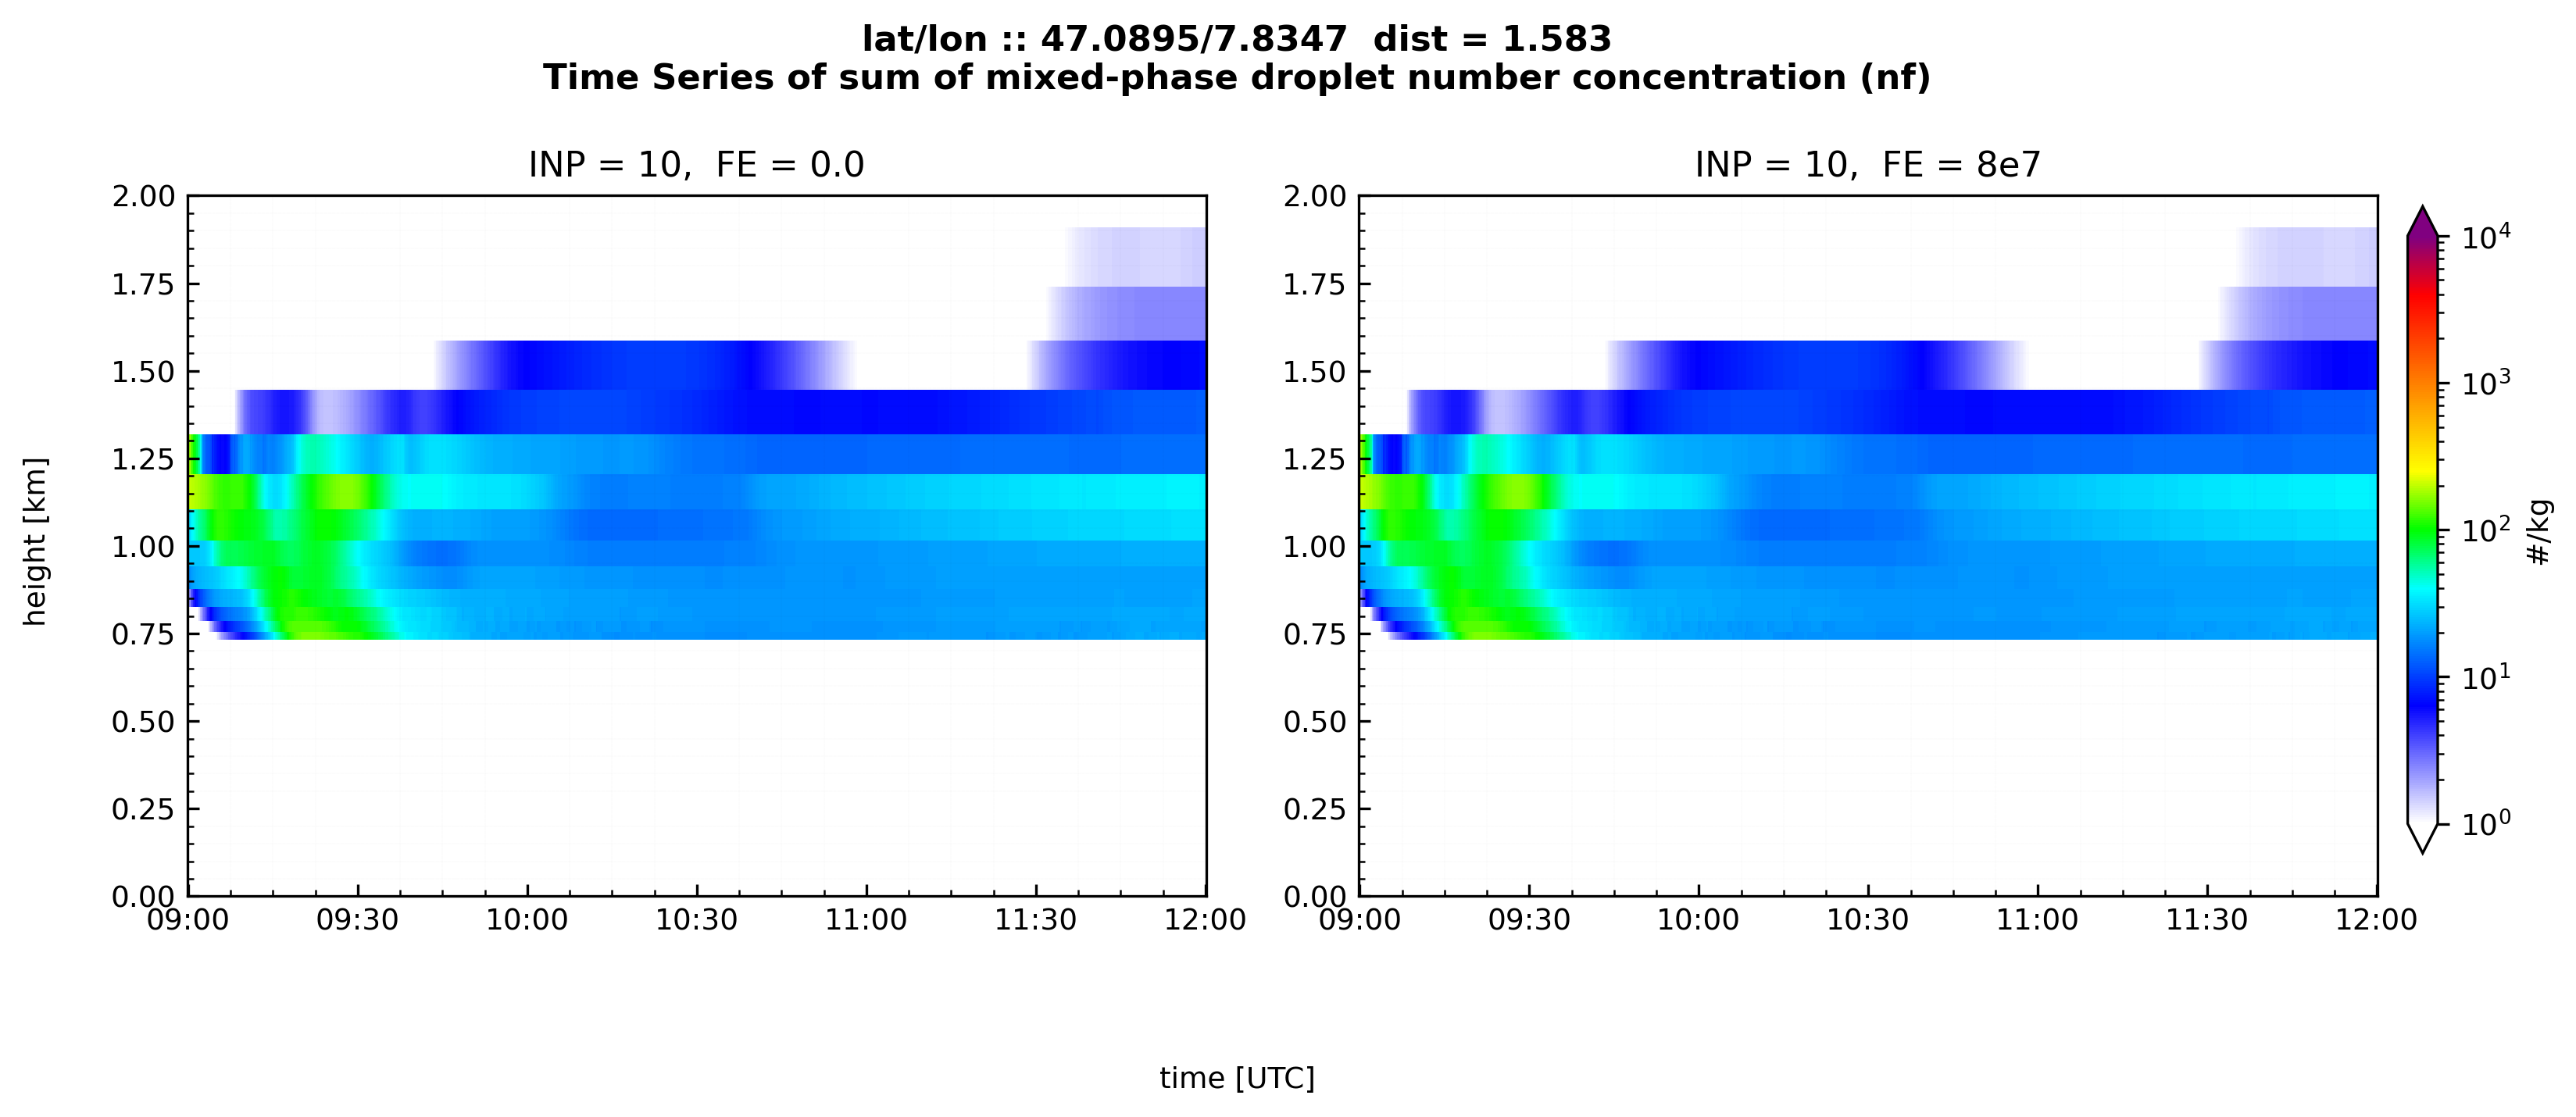

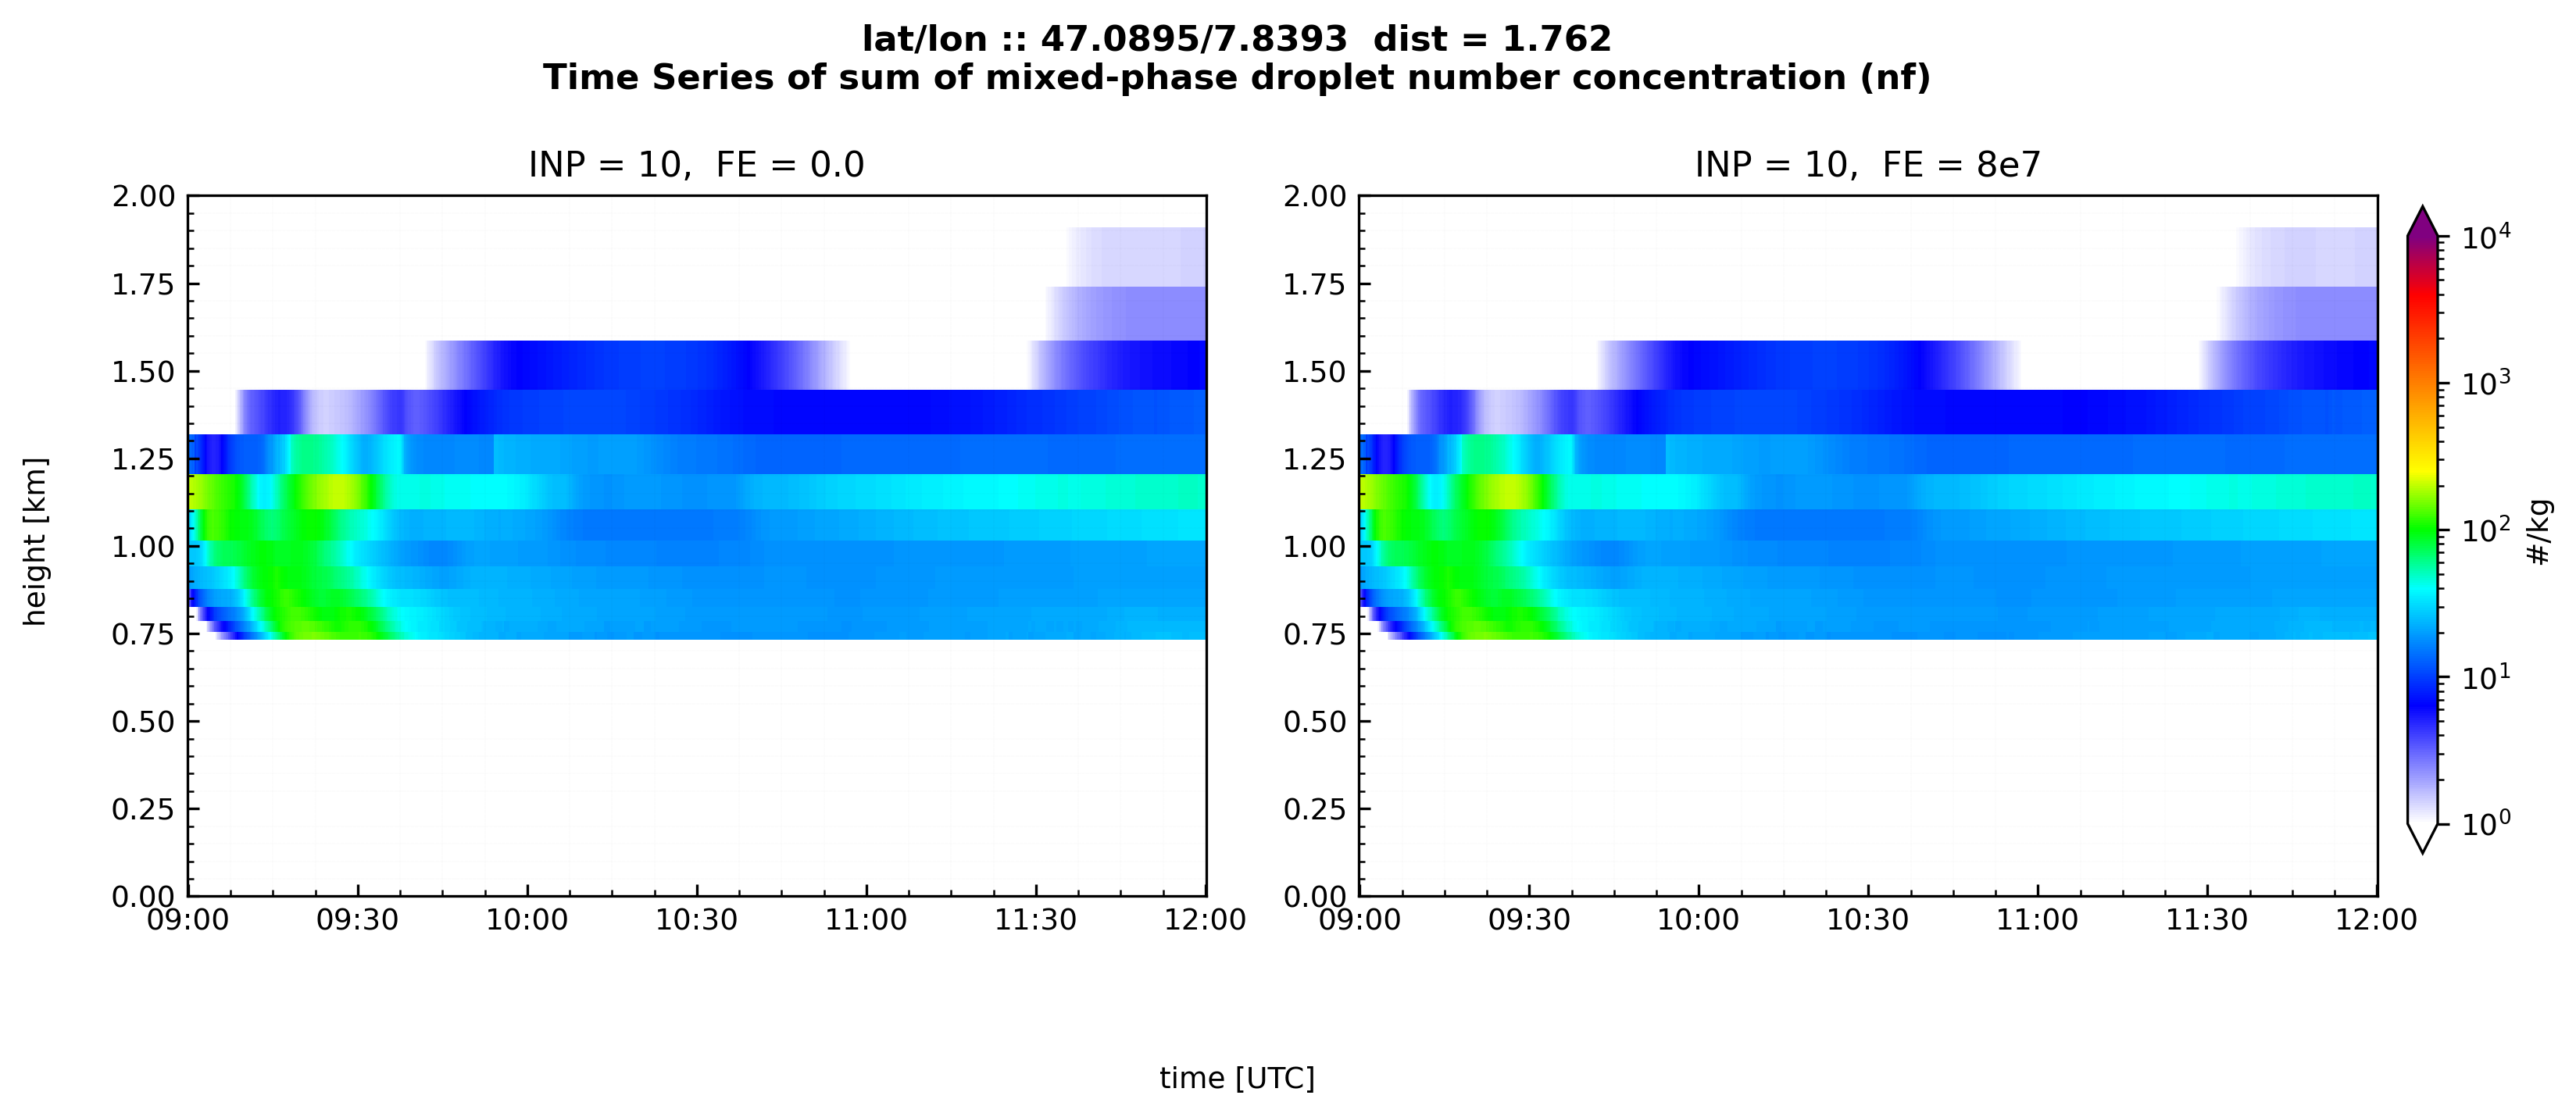

In [ ]:
importlib.reload(vizz)

for iidX, iidY in tqdm(zip(idX, idY)):
    plot6 = vizz.MultiPanelPlot(
        data, 
        metadata    = metadata,
        varname     = 'nf', 
        nrows       = 1, 
        ncols       = 2, 
        mode        = 'timeseries',
        ymin        = 0, 
        ymax        = 2,
        latlon      = True,
        idX         = iidX,
        idY         = iidY,
        )
    
    lat, lon = plot6.y[iidY], plot6.x[iidX]
    dist = vizz.haversine_distance(plot6.y[12], plot6.x[12], plot6.y[iidY], plot6.x[iidX]) * 1.0e-3
    plot6.fig.suptitle(f'lat/lon :: {lat:.4f}/{lon:.4f}  dist = {dist:.3f}\nTime Series of sum of {ds.attrs["long_name"]} ({var_name})', weight='bold')
    
    plot6.save_figure(f'/{plots_path}/{iidX}-{iidY}-ts.png')
    

In [11]:
list(data.keys())

['3D_20230821_172639',
 '3D_20230821_172722',
 '3D_20230821_172859',
 '3D_20230821_172929',
 '3D_20230821_173020',
 '3D_20230821_173051',
 '3D_20230821_173224',
 '3D_20230821_173311',
 '3D_20230821_173350',
 '3D_20230821_173420',
 '3D_20230821_173511',
 '3D_20230821_173542']

In [12]:
data[next(iter(data))].z[41].values

array(41)

In [13]:
data[next(iter(data))]
HHLd = np.array(
    [21.500002  , 20.514286  , 19.556965  , 18.62768   , 17.72607   ,
    16.851786  , 16.004465  , 15.183751  , 14.389286  , 13.620715  ,
    12.87768   , 12.159819  , 11.474235  , 10.83433   , 10.231516  ,
    9.650918  ,  9.092202  ,  8.555033  ,  8.039072  ,  7.5439944 ,
    7.069464  ,  6.615141  ,  6.180692  ,  5.76579   ,  5.370097  ,
    4.993273  ,  4.634993  ,  4.294922  ,  3.9727197 ,  3.6680555 ,
    3.3805976 ,  3.110009  ,  2.855953  ,  2.6181023 ,  2.3961203 ,
    2.18967   ,  1.9984195 ,  1.8220367 ,  1.6601849 ,  1.5125275 ,
    1.3787366 ,  1.2584761 ,  1.151409  ,  1.0572032 ,  0.9755266 ,
    0.9060427 ,  0.84841454,  0.8023148 ,  0.76740676,  0.7433537 ]
    )

HHLd[41]

1.2584761

In [14]:
data_path

'/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/'

In [15]:
# distance between to grid points
lat_start, lon_start = 47.045, 7.775
lat_end, lon_end = 47.0910, 7.8388

dx = vizz.haversine_distance(lat_start, lon_start, lat_start, lon_start+0.005)
dy = vizz.haversine_distance(lat_start, lon_start, lat_start+0.005, lon_start)

print('dy = ', dy)
print('dx = ', dx)

dy =  555.9746332234664
dx =  378.8543171440329


In [16]:
print(HHLd)
print(np.sum(HHLd))
print(np.diff(HHLd))

[21.500002   20.514286   19.556965   18.62768    17.72607    16.851786
 16.004465   15.183751   14.389286   13.620715   12.87768    12.159819
 11.474235   10.83433    10.231516    9.650918    9.092202    8.555033
  8.039072    7.5439944   7.069464    6.615141    6.180692    5.76579
  5.370097    4.993273    4.634993    4.294922    3.9727197   3.6680555
  3.3805976   3.110009    2.855953    2.6181023   2.3961203   2.18967
  1.9984195   1.8220367   1.6601849   1.5125275   1.3787366   1.2584761
  1.151409    1.0572032   0.9755266   0.9060427   0.84841454  0.8023148
  0.76740676  0.7433537 ]
360.43145739999994
[-0.985716   -0.957321   -0.929285   -0.90161    -0.874284   -0.847321
 -0.820714   -0.794465   -0.768571   -0.743035   -0.717861   -0.685584
 -0.639905   -0.602814   -0.580598   -0.558716   -0.537169   -0.515961
 -0.4950776  -0.4745304  -0.454323   -0.434449   -0.414902   -0.395693
 -0.376824   -0.35828    -0.340071   -0.3222023  -0.3046642  -0.2874579
 -0.2705886  -0.254056   -0.23

In [17]:
i_meteo = '08'
meteo_path = data_path + f'M_{i_meteo}-20230826_173042.nc'
ds_meteo = xr.open_mfdataset(meteo_path)

In [18]:
ds_meteo

<xarray.Dataset>
Dimensions:              (time: 289, HHLd: 51, HMLd: 50, bins: 66, tfr: 30)
Coordinates:
  * time                 (time) datetime64[ns] 2023-01-25T09:00:35 ... 2023-0...
  * HHLd                 (HHLd) float32 2.2e+04 2.1e+04 ... 829.4 810.8
  * HMLd                 (HMLd) float32 2.15e+04 2.051e+04 ... 843.9 820.1
Dimensions without coordinates: bins, tfr
Data variables: (12/136)
    RGRENZ_left          (bins) float32 dask.array<chunksize=(66,), meta=np.ndarray>
    RGRENZ_right         (bins) float32 dask.array<chunksize=(66,), meta=np.ndarray>
    U                    (time, HMLd) float32 dask.array<chunksize=(289, 50), meta=np.ndarray>
    V                    (time, HMLd) float32 dask.array<chunksize=(289, 50), meta=np.ndarray>
    W                    (time, HHLd) float32 dask.array<chunksize=(289, 51), meta=np.ndarray>
    T                    (time, HMLd) float32 dask.array<chunksize=(289, 50), meta=np.ndarray>
    ...                   ...
    SUM_N_kqwf           (time, HMLd, bins) float32 dask.array<chunksize=(289, 50, 66), meta=np.ndarray>
    SUM_N_dqfwmelt       (time, HMLd, bins) float32 dask.array<chunksize=(289, 50, 66), meta=np.ndarray>
    SUM_N_HOMN           (time, HMLd, bins) float32 dask.array<chunksize=(289, 50, 66), meta=np.ndarray>
    SUM_N_HOMQ           (time, HMLd, bins) float32 dask.array<chunksize=(289, 50, 66), meta=np.ndarray>
    VW                   (time, HMLd, bins) float32 dask.array<chunksize=(289, 50, 66), meta=np.ndarray>
    VF                   (time, HMLd, bins) float32 dask.array<chunksize=(289, 50, 66), meta=np.ndarray>

In [19]:
[f'{data_path}{name}' for name in ['3D_20230830_111543.nc', '3D_20230830_111709.nc']]

['/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/3D_20230830_111543.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/3D_20230830_111709.nc']

{'20230830_111543': {'starttime': '1693386943', 'job_id': '6702500', 'nodeX': 'l10292', 'domain': '42x32', 'LMGRID.startlat_tot': '-0.08', 'LMGRID.startlon_tot': '-0.08', 'LMGRID.pollat': '42.920', 'LMGRID.pollon': '-172.149', 'LMGRID.dlon': '0.005', 'LMGRID.dlat': '0.005', 'LMGRID.ie_tot': '42', 'LMGRID.je_tot': '32', 'LMGRID.ke_tot': '50', 'SBM_PAR.lsbm': '.true.', 'SBM_PAR.iimfr': '10', 'SBM_PAR.ifrier': '1', 'SBM_PAR.idepo': '0', 'SBM_PAR.imelt': '1', 'SBM_PAR.ikofr': '1', 'SBM_PAR.ibrea': '1', 'SBM_PAR.ikoll': '2', 'SBM_PAR.iice': '1', 'SBM_PAR.iinsol': '7', 'SBM_PAR.ikeis': '1', 'SBM_PAR.iideal': '1', 'SBM_PAR.epsi': '0.5', 'SBM_PAR.itimemax': '4', 'SBM_PAR.iap': '1', 'SBM_PAR.ihomfr': '1', 'SBM_PAR.mpstepsmax': '1', 'SBM_PAR.fd4_blsize': '2', 'SBM_PAR.2': '2', 'SBM_PAR.4': '4', 'SBM_PAR.nc_output_hcomb': '0', 'SBM_PAR.10800': '10800', 'SBM_PAR.120': '120', 'SBM_PAR.outputname': '3D_20230830_111543', 'SBM_PAR.output_groups': '1100001', 'SBM_PAR.fd4_lbmethod': '3', 'SBM_PAR.fd4_lb

IndexError: Index 400 is out of bounds for axis 0 with size 87

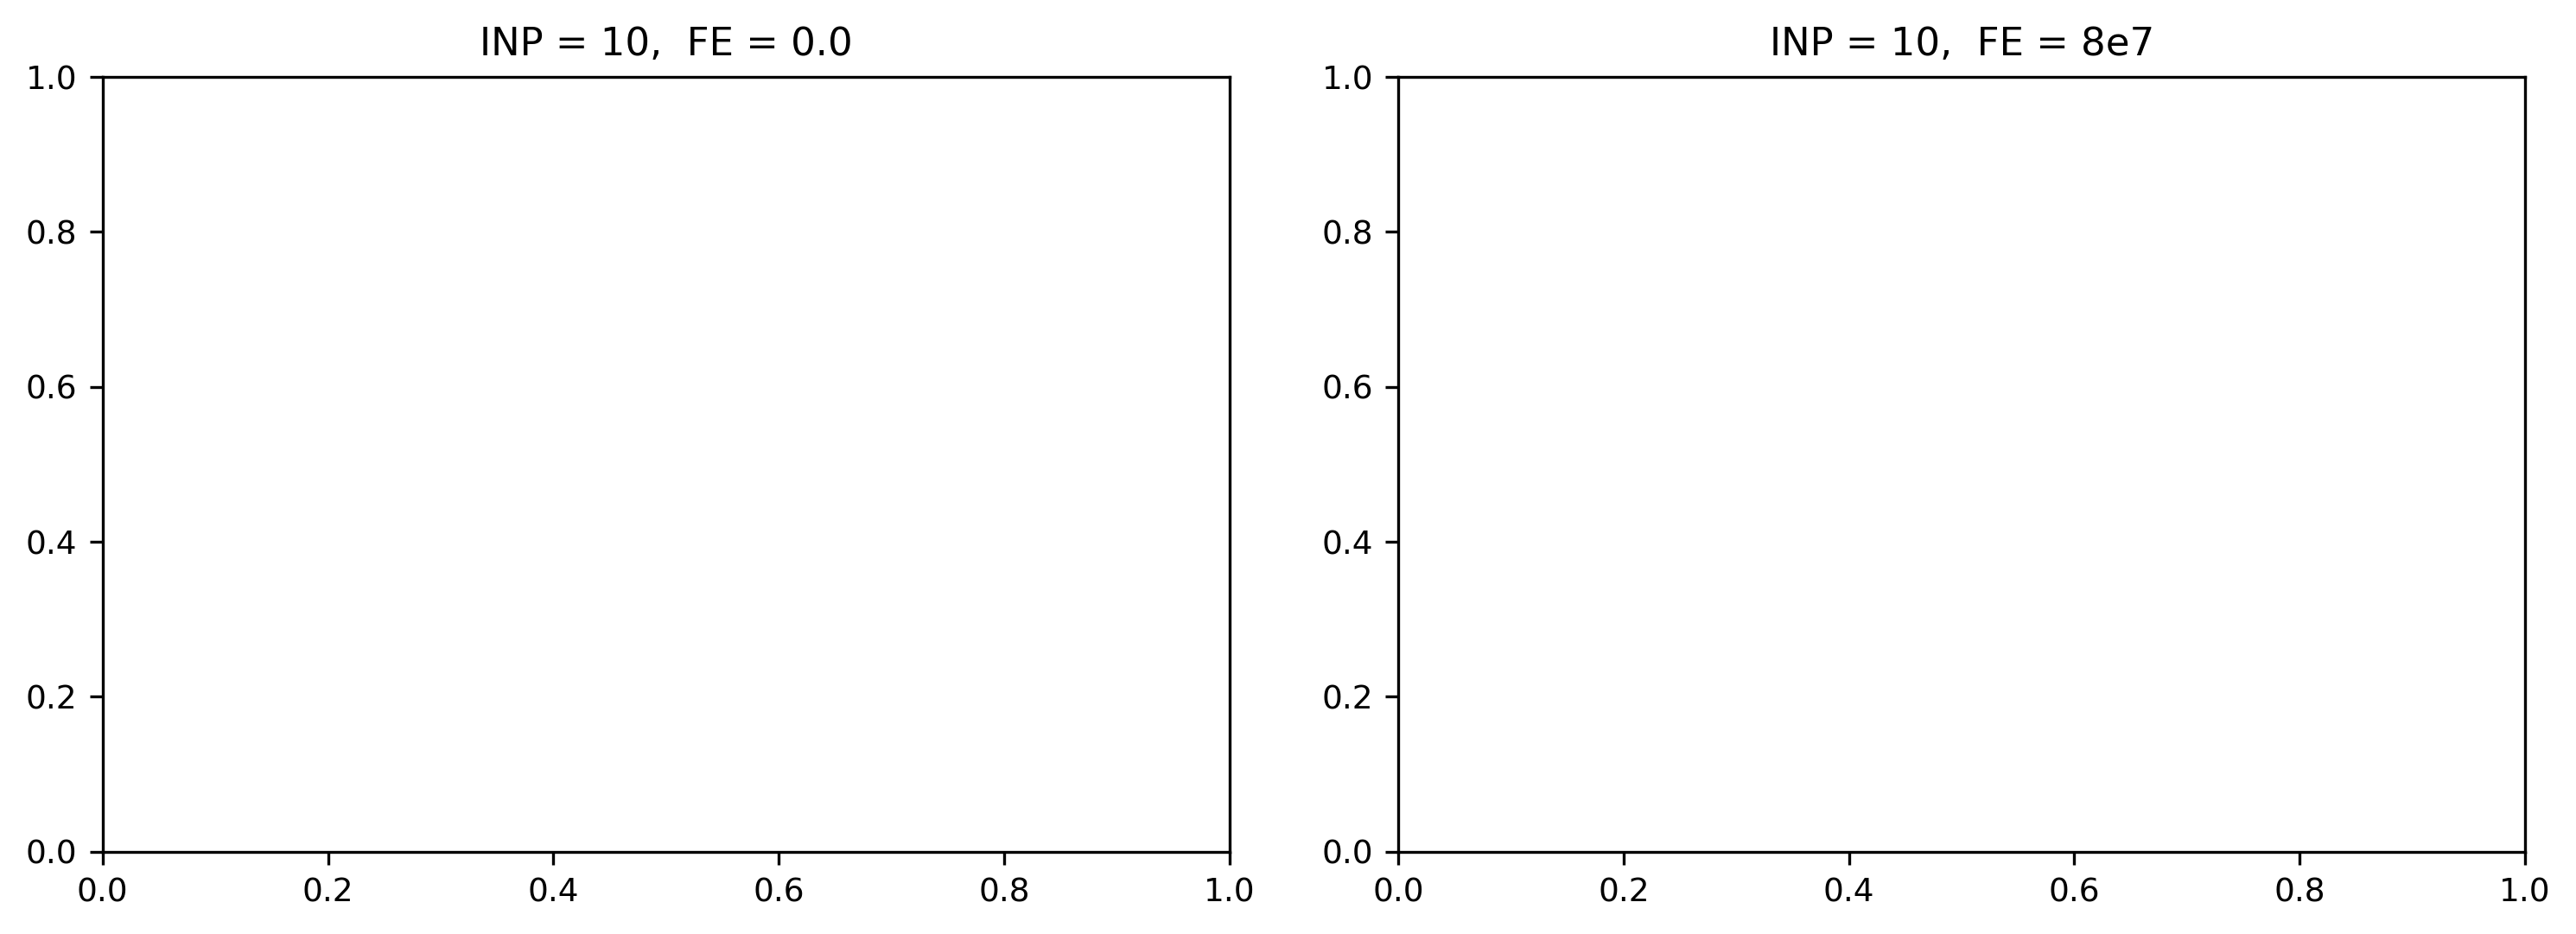

In [40]:

importlib.reload(vizz)

key = '3D_20230821_172859'
var_name = 'nf'

with open(f'{data_path}cs-eriswil__20230830_111543.json') as f:
   metadata2 = json.load(f)

print(metadata2)

plot1 = vizz.MultiPanelPlot(
    [f'{data_path}{name}' for name in ['3D_20230830_111543.nc', '3D_20230830_111709.nc']], 
    metadata    = metadata2,
    varname     = var_name, 
    nrows       = 1, 
    ncols       = 2, 
    mode        = 'area', 
    vmin        = 1.0, 
    vmax        = 1.0e4,
    timeframe   = 'single', # 'all', 'single'
    timestep0   = 400,
    latlon      = True,
    windvectors = False
    )



In [37]:
Zn.shape

(56, 26, 36)

In [1]:

norm = colors.LogNorm(1.0, 1.0e4)
ds_3d_n = xr.open_mfdataset(f'{data_path}3D_20230830_111543.nc')
ds_3d_f = xr.open_mfdataset(f'{data_path}3D_20230830_111709.nc')
Zn = ds_3d_n['nf'][:, 41:45, :, :, :].sum(('z', 'bin'))
Zf = ds_3d_f['nf'][:, 41:45, :, :, :].sum(('z', 'bin'))

fig10, ax10 = plt.subplots(ncols=2, figsize=(14, 3))
pmeshn = Zn[20, :, :].plot(ax=ax10[0], norm=norm, cmap=cmap)
pmeshf = Zf[20, :, :].plot(ax=ax10[1], norm=norm, cmap=cmap)

for i in tqdm(range(Zn.time.size)):
    pmeshn.set_array(Zn[i, :, :].values.ravel())
    pmeshf.set_array(Zf[i, :, :].values.ravel())
    fig10.savefig(f'{plots_path}/{i}-test.png')

NameError: name 'colors' is not defined

In [11]:
np.sqrt((9*0.380)**2 + (4*0.550)**2)

4.06649726423122

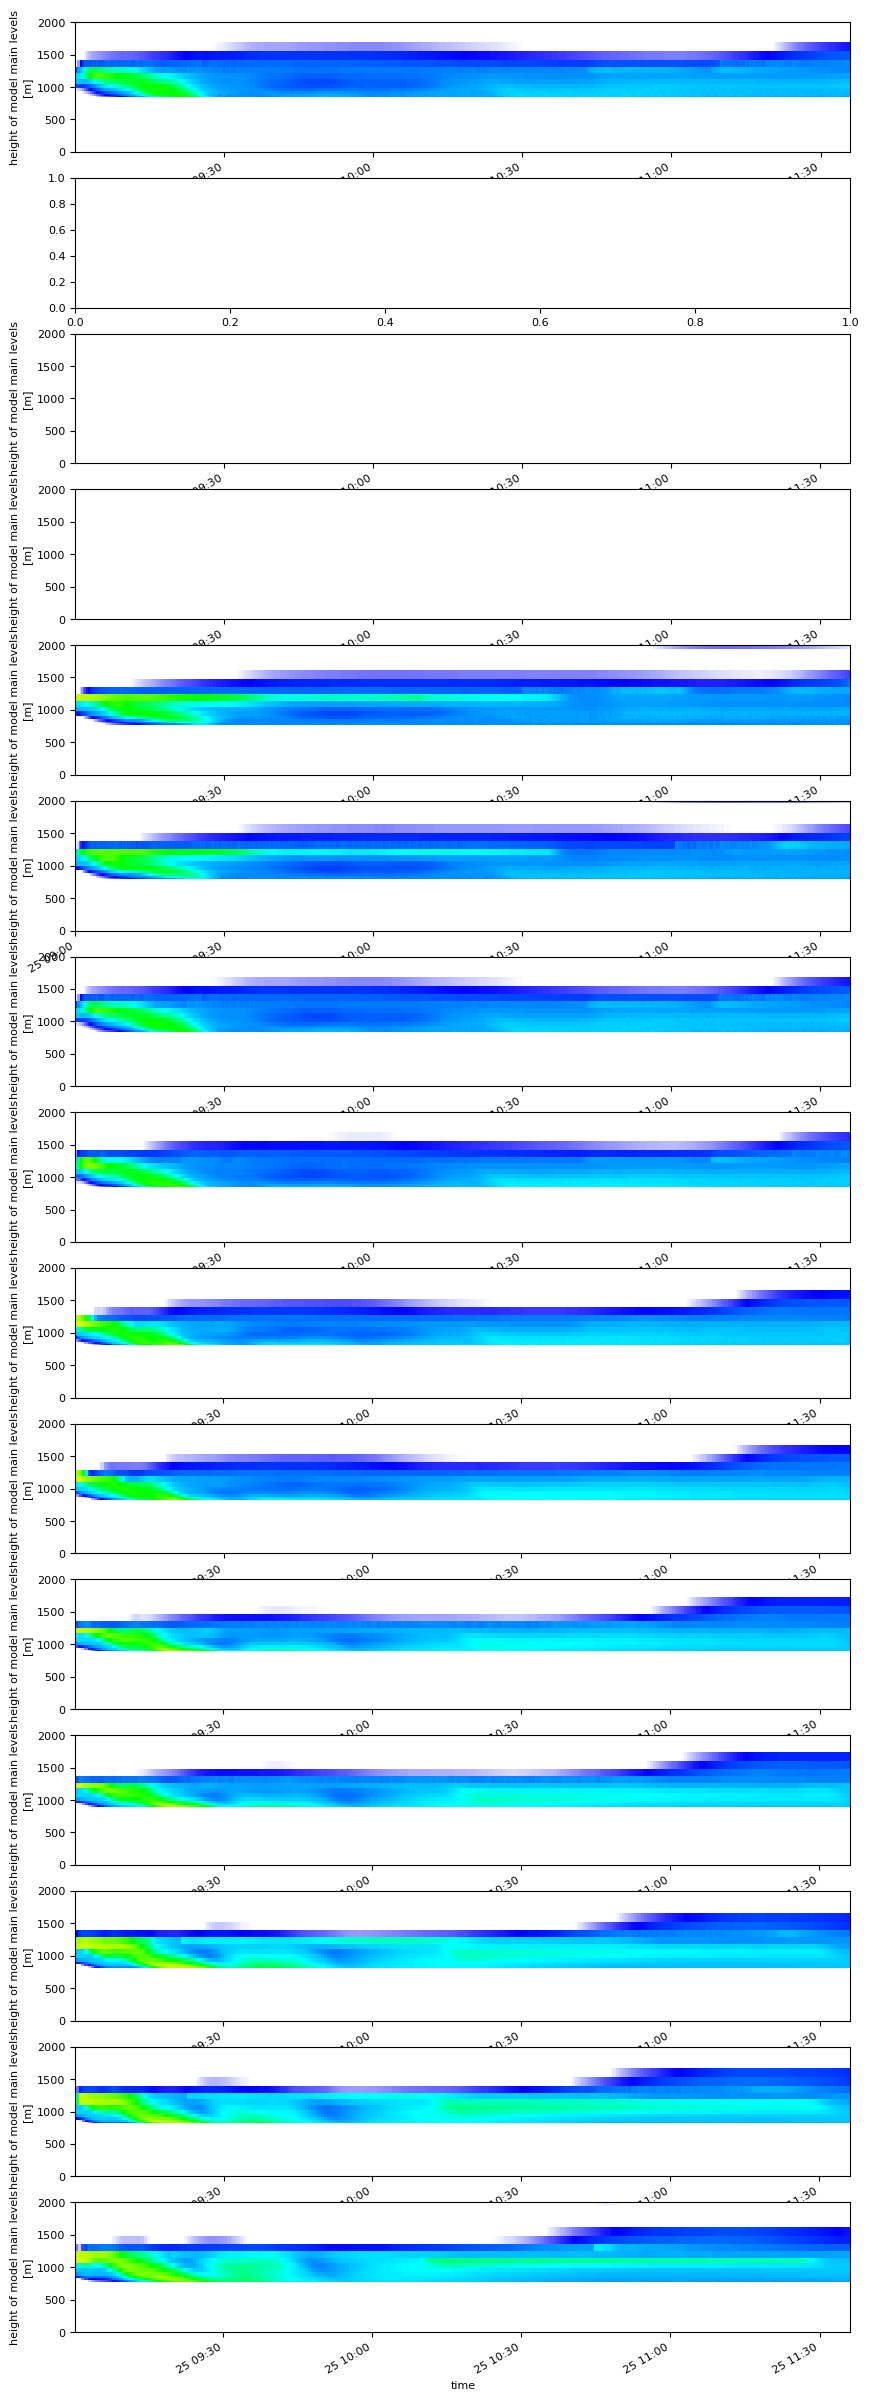

In [47]:
fig8, ax8 = plt.subplots(nrows=15, figsize=(10, 30))


for i in range(0, 15): 
    try:
        ds_meteo7 = xr.open_mfdataset(
            f'/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01/M_{str(i).zfill(2)}-20230826_173042.nc'
            )
    except:
        continue
    #ds_meteo7['QI'].T.plot()

    norm = colors.LogNorm(1.0, 1.0e4)
    ds_meteo7['NF'].sum('bins').T.plot(ax = ax8[i], norm=norm, cmap=cmap, add_colorbar=False)
    ax8[i].set_ylim(0, 2000)

In [34]:

# for i in range(5, 13):
#     x = ds_meteo.time.values
#     y = ds_meteo.HMLd.values
#     ds_meteo = xr.open_mfdataset(f'{data_path}/M_{str(i+2).zfill(2)}-20230826_173042.nc')

#     try:
#         pm1 = ax3[i, 0].pcolormesh(x, y, ds_meteo['QI'].values.T, norm=colors.LogNorm(1.0e-10, 1.0e-6), cmap=cmap)
#         pm2 = ax3[i, 1].pcolormesh(x, y, ds_meteo['QC'].values.T, norm=colors.LogNorm(1.0e-7, 1.0e-2), cmap=cmap)
#         ax3[i, 0].set_ylim(0,2000)
#         ax3[i, 1].set_ylim(0,2000)
#     except:
#         pass



In [35]:

meteo_paths = []
for i in range(8, 14):

    i_meteo = str(i+2).zfill(2)
    meteo_paths.append(f'{data_path}/M_{i_meteo}-20230826_173042.nc')

meteo_paths = sorted(meteo_paths)
print(meteo_paths)

ds_meteo = xr.open_mfdataset(meteo_paths, concat_dim='pathway', combine='nested')

ds_meteo

['/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01//M_10-20230826_173042.nc', '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01//M_11-20230826_173042.nc', '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01//M_12-20230826_173042.nc', '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01//M_13-20230826_173042.nc', '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01//M_14-20230826_173042.nc', '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01//M_15-20230826_173042.nc']


<xarray.Dataset>
Dimensions:              (time: 316, HHLd: 241, HMLd: 240, pathway: 6,
                          bins: 66, tfr: 30)
Coordinates:
  * time                 (time) datetime64[ns] 2023-01-25T09:00:30 ... 2023-0...
  * HHLd                 (HHLd) float32 768.0 777.0 786.6 ... 2.1e+04 2.2e+04
  * HMLd                 (HMLd) float32 777.3 786.3 801.3 ... 2.051e+04 2.15e+04
Dimensions without coordinates: pathway, bins, tfr
Data variables: (12/136)
    RGRENZ_left          (pathway, bins) float32 dask.array<chunksize=(1, 66), meta=np.ndarray>
    RGRENZ_right         (pathway, bins) float32 dask.array<chunksize=(1, 66), meta=np.ndarray>
    U                    (pathway, time, HMLd) float32 dask.array<chunksize=(1, 316, 240), meta=np.ndarray>
    V                    (pathway, time, HMLd) float32 dask.array<chunksize=(1, 316, 240), meta=np.ndarray>
    W                    (pathway, time, HHLd) float32 dask.array<chunksize=(1, 316, 241), meta=np.ndarray>
    T                    (pathway, time, HMLd) float32 dask.array<chunksize=(1, 316, 240), meta=np.ndarray>
    ...                   ...
    SUM_N_kqwf           (pathway, time, HMLd, bins) float32 dask.array<chunksize=(1, 316, 240, 66), meta=np.ndarray>
    SUM_N_dqfwmelt       (pathway, time, HMLd, bins) float32 dask.array<chunksize=(1, 316, 240, 66), meta=np.ndarray>
    SUM_N_HOMN           (pathway, time, HMLd, bins) float32 dask.array<chunksize=(1, 316, 240, 66), meta=np.ndarray>
    SUM_N_HOMQ           (pathway, time, HMLd, bins) float32 dask.array<chunksize=(1, 316, 240, 66), meta=np.ndarray>
    VW                   (pathway, time, HMLd, bins) float32 dask.array<chunksize=(1, 316, 240, 66), meta=np.ndarray>
    VF                   (pathway, time, HMLd, bins) float32 dask.array<chunksize=(1, 316, 240, 66), meta=np.ndarray>

In [36]:
meteo_paths

['/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01//M_10-20230826_173042.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01//M_11-20230826_173042.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01//M_12-20230826_173042.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01//M_13-20230826_173042.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01//M_14-20230826_173042.nc',
 '/work/bb1262/user/schimmel/cosmo-specs-torch/cosmo-specs/testcases/RUN_ERISWILL_TESTCASE01//M_15-20230826_173042.nc']

(0.0, 2000.0)

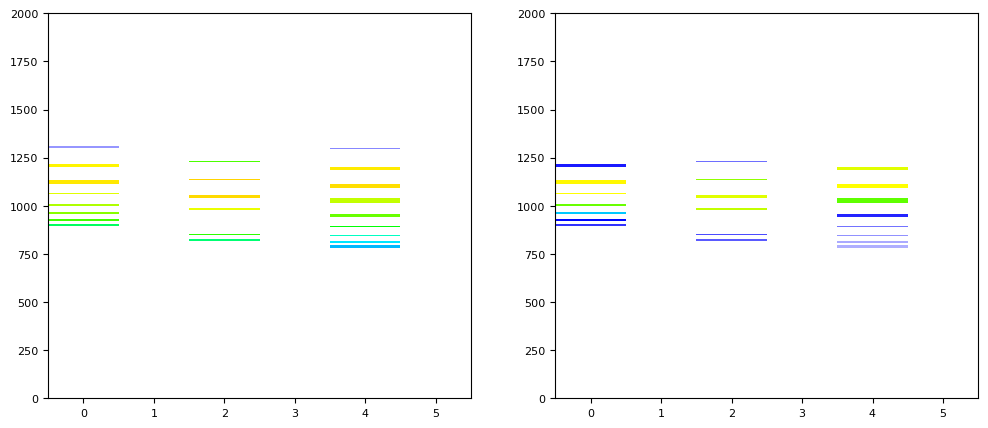

In [37]:


import datetime

import matplotlib.colors as colors
norm = colors.LogNorm(1.0e-10, 1.0e-1)

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'mycmap', [
        (0, 'white'), (0.2, 'blue'), (0.4, 'cyan'), (0.5, 'lime'), 
        (0.6, 'yellow'), (0.9, 'red'), (1, 'purple')
        ]
    ) 

pmeshs = [] 


fig3, ax3 = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

x = ds_meteo.time.values
y = ds_meteo.HMLd.values

pm1 = ax3[0].pcolormesh(np.arange(6), y, ds_meteo['QI'][:, 100, :].T.values, norm=colors.LogNorm(1.0e-10, 1.0e-6), cmap=cmap)
pm2 = ax3[1].pcolormesh(np.arange(6), y, ds_meteo['QC'][:, 100, :].T.values, norm=colors.LogNorm(1.0e-7, 1.0e-2), cmap=cmap)
ax3[0].set_ylim(0, 2000)
ax3[1].set_ylim(0, 2000)


# for iP in tqdm(range(1)):

#     # dt0 = datetime.datetime.strptime("2023012509", "%Y%m%d%H")
#     # dti = dt0 + iT*datetime.timedelta(seconds=15)
#     # ax3[0].set_title(f'{str(dti)} - height: {y[4]:.3f} - {y[10]:.3f} [km]\n\
#     #              sum of {ds_meteo["QI"].attrs["standard_name"]}', weight='bold')
    
#     # ax3[1].set_title(f'{str(dti)} - height: {y[4]:.3f} - {y[10]:.3f} [km]\n\
#     #              sum of {ds_meteo["QC"].attrs["standard_name"]}', weight='bold')
    
#     pm1.set_array(ds_meteo['QI'][:, iT, :].values.T.ravel())#order='F'))
#     pm2.set_array(ds_meteo['QC'][:, iT, :].values.T.ravel())#order='F'))
#     fig3.savefig(f'/{plots_path}/{str(iT).zfill(3)}_M_cross.png', dpi=300, facecolor='white')




In [38]:
ds_meteo['VW']

<xarray.DataArray 'VW' (pathway: 6, time: 316, HMLd: 240, bins: 66)>
dask.array<concatenate, shape=(6, 316, 240, 66), dtype=float32, chunksize=(1, 316, 240, 66), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2023-01-25T09:00:30 ... 2023-01-25T11:11:15
  * HMLd     (HMLd) float32 777.3 786.3 801.3 ... 1.956e+04 2.051e+04 2.15e+04
Dimensions without coordinates: pathway, bins
Attributes:
    standard_name:  fall velocity water droplets
    units:          m s-1